In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

def load_data():
    # Assuming the data is stored in a JSON file
    file_path = '../data/detailed_reserves_data.json'
    with open(file_path, 'r') as file:
        data = json.load(file)
    return pd.DataFrame(data)

def preprocess_data(df):
    # Filter for USD Coin data
    usd_coin_df = df[df['name'] == 'USD Coin']
    usd_coin_df['date'] = pd.to_datetime(usd_coin_df['timestamp'], unit='s')
    usd_coin_df.set_index('date', inplace=True)
    usd_coin_df.sort_index(inplace=True)
    return usd_coin_df['liquidityRate']

def decompose_series(series):
    result = seasonal_decompose(series, model='additive', period=30)  # Adjust the period based on the data frequency
    result.plot()
    plt.show()
    return result

def test_stationarity(series):
    result = adfuller(series.dropna())
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

def fit_sarima(series):
    model = SARIMAX(series, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    model_fit = model.fit(disp=False)
    print(model_fit.summary())
    return model_fit

def forecast(model_fit):
    forecast = model_fit.forecast(steps=12)  # Forecast the next 12 time points
    plt.figure(figsize=(10, 5))
    plt.plot(series, label='Historical')
    plt.plot(forecast, label='Forecast')
    plt.legend()
    plt.show()

# Load and preprocess data
df = load_data()
usd_coin_liquidity = preprocess_data(df)

# Decompose the time series
decomposed = decompose_series(usd_coin_liquidity)

# Stationarity test
test_stationarity(usd_coin_liquidity)

# Fit SARIMA model
model_fit = fit_sarima(usd_coin_liquidity)

# Forecast
forecast(model_fit)


FileNotFoundError: [Errno 2] No such file or directory: '../data/detailed_reserves_data.json'

Correlation Matrix for 2021:


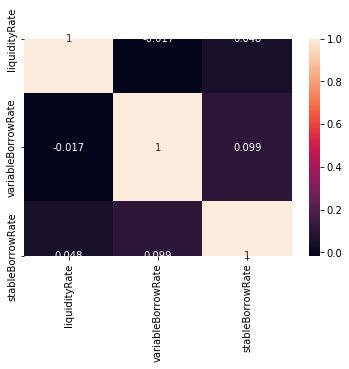

Correlation Matrix for 2022:


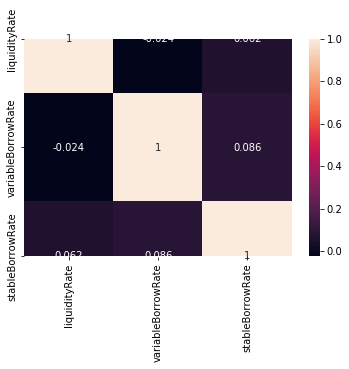

Correlation Matrix for 2023:


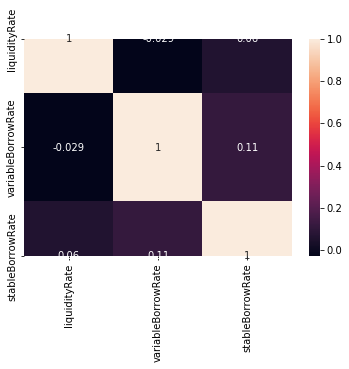

Time Series Analysis for USD Coin:


KeyError: 'timestamp'

In [3]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def load_data(year):
    file_path = f'../data/detailed_reserves_data_{year}.json'
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

def preprocess_data(data):
    flattened_data = []
    for month_data in data:
        for reserve in month_data:
            reserve['liquidityRate'] = float(reserve['liquidityRate']) / 1e27  # Normalize the rate
            reserve['variableBorrowRate'] = float(reserve['variableBorrowRate']) / 1e27
            reserve['stableBorrowRate'] = float(reserve['stableBorrowRate']) / 1e27
            flattened_data.append(reserve)
    return pd.DataFrame(flattened_data)

def compute_correlation(df):
    corr_matrix = df[['liquidityRate', 'variableBorrowRate', 'stableBorrowRate']].corr()
    sns.heatmap(corr_matrix, annot=True)
    plt.show()
    return corr_matrix

def time_series_analysis(df, asset_name):
    asset_df = df[df['name'] == asset_name]
    asset_df.index = pd.to_datetime(asset_df['timestamp'], unit='s')
    asset_df['liquidityRate'].plot(title=f"{asset_name} Liquidity Rate Over Time")
    plt.show()

# Load and preprocess data for each year
years = ['2021', '2022', '2023']
all_data = {}

for year in years:
    raw_data = load_data(year)
    processed_df = preprocess_data(raw_data)
    all_data[year] = processed_df

    print(f"Correlation Matrix for {year}:")
    compute_correlation(processed_df)

    if year == '2023':  # Specific analysis for USD Coin in 2023
        print("Time Series Analysis for USD Coin:")
        time_series_analysis(processed_df, 'USD Coin')


In [4]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler

# Assuming df is your preprocessed DataFrame
# Feature Engineering
df['liquidityRate_derivative'] = df['liquidityRate'].diff()  # First derivative
df['liquidityRate_to_variableBorrowRate'] = df['liquidityRate'] / df['variableBorrowRate']
df['rolling_avg_liquidity'] = df['liquidityRate'].rolling(window=5).mean()  # 5 periods rolling average

# Normalize features for LSTM usage
scaler = MinMaxScaler()
df[['liquidityRate', 'variableBorrowRate', 'stableBorrowRate', 'liquidityRate_derivative',
    'liquidityRate_to_variableBorrowRate', 'rolling_avg_liquidity']] = scaler.fit_transform(
    df[['liquidityRate', 'variableBorrowRate', 'stableBorrowRate', 'liquidityRate_derivative',
        'liquidityRate_to_variableBorrowRate', 'rolling_avg_liquidity']]
)

# ARIMA Model for 'liquidityRate'
model = ARIMA(df['liquidityRate'], order=(1, 1, 1))  # ARIMA model setup
fitted_model = model.fit()  # Fit model
predictions = fitted_model.forecast(steps=5)  # Forecast next 5 steps

print(predictions)


KeyError: 'liquidityRate'

In [5]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler

def load_data(year):
    """Loads data from a JSON file for a given year."""
    file_path = f'../data/detailed_reserves_data_{year}.json'
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

def preprocess_data(data):
    """Converts data into a DataFrame and scales rates."""
    flattened_data = []
    for month_data in data:
        for reserve in month_data:
            flattened_data.append({
                'liquidityRate': float(reserve['liquidityRate']) / 1e27,
                'variableBorrowRate': float(reserve['variableBorrowRate']) / 1e27,
                'stableBorrowRate': float(reserve['stableBorrowRate']) / 1e27
            })
    df = pd.DataFrame(flattened_data)
    return df

def feature_engineering(df):
    """Adds derivative and ratio features, along with rolling averages."""
    df['liquidityRate_derivative'] = df['liquidityRate'].diff()  # First derivative
    df['liquidityRate_to_variableBorrowRate'] = df['liquidityRate'] / df['variableBorrowRate']
    df['rolling_avg_liquidity'] = df['liquidityRate'].rolling(window=5).mean()  # 5 periods rolling average
    return df

def normalize_features(df):
    """Normalizes features using MinMaxScaler."""
    scaler = MinMaxScaler()
    feature_columns = ['liquidityRate', 'variableBorrowRate', 'stableBorrowRate', 'liquidityRate_derivative',
                       'liquidityRate_to_variableBorrowRate', 'rolling_avg_liquidity']
    df[feature_columns] = scaler.fit_transform(df[feature_columns])
    return df

def setup_arima_model(df):
    """Sets up and fits an ARIMA model on the 'liquidityRate' feature."""
    model = ARIMA(df['liquidityRate'], order=(1, 1, 1))  # Configure ARIMA model
    fitted_model = model.fit()  # Fit model
    return fitted_model

# Main execution logic
if __name__ == "__main__":
    years = ['2021', '2022', '2023']  # List of years to process
    for year in years:
        data = load_data(year)
        df = preprocess_data(data)
        df = feature_engineering(df)
        df = normalize_features(df)
        arima_model = setup_arima_model(df)
        print(f"Forecast for {year}:")
        print(arima_model.forecast(steps=5))  # Forecast next 5 steps


Forecast for 2021:
539    0.068778
540    0.064376
541    0.064658
542    0.064640
543    0.064641
Name: predicted_mean, dtype: float64
Forecast for 2022:
697    0.052599
698    0.050212
699    0.050321
700    0.050316
701    0.050316
Name: predicted_mean, dtype: float64
Forecast for 2023:
720    0.050808
721    0.048605
722    0.048701
723    0.048697
724    0.048697
Name: predicted_mean, dtype: float64


In [10]:
import pandas as pd
import json
from sklearn.preprocessing import MinMaxScaler

def load_and_process_json(file_path):
    """Load JSON data and convert it to a DataFrame."""
    with open(file_path, 'r') as file:
        data = json.load(file)

    flattened_data = []
    for month_data in data:
        for reserve in month_data:
            flattened_data.append({
                'name': reserve['name'],  # Include the name field
                'liquidityRate': float(reserve['liquidityRate']) / 1e27,
                'variableBorrowRate': float(reserve['variableBorrowRate']) / 1e27,
                'stableBorrowRate': float(reserve['stableBorrowRate']) / 1e27
            })
    return pd.DataFrame(flattened_data)

# Paths to your JSON files
file_paths = ['../data/detailed_reserves_data_2021.json', '../data/detailed_reserves_data_2022.json', '../data/detailed_reserves_data_2023.json']
all_data_frames = [load_and_process_json(path) for path in file_paths]

# Concatenate all yearly data into a single DataFrame
complete_data = pd.concat(all_data_frames, ignore_index=True)

# Optionally, normalize the entire DataFrame
scaler = MinMaxScaler()
complete_data[['liquidityRate', 'variableBorrowRate', 'stableBorrowRate']] = scaler.fit_transform(
    complete_data[['liquidityRate', 'variableBorrowRate', 'stableBorrowRate']]
)

# Save the DataFrame to a CSV file
complete_data.to_csv('consolidated_liquidity_data.csv', index=False)

print("Data has been processed and saved to consolidated_liquidity_data.csv.")


Data has been processed and saved to consolidated_liquidity_data.csv.


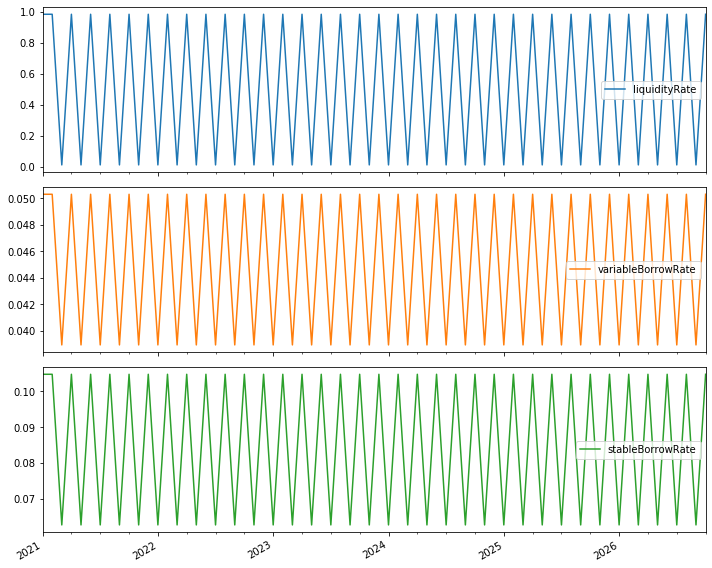

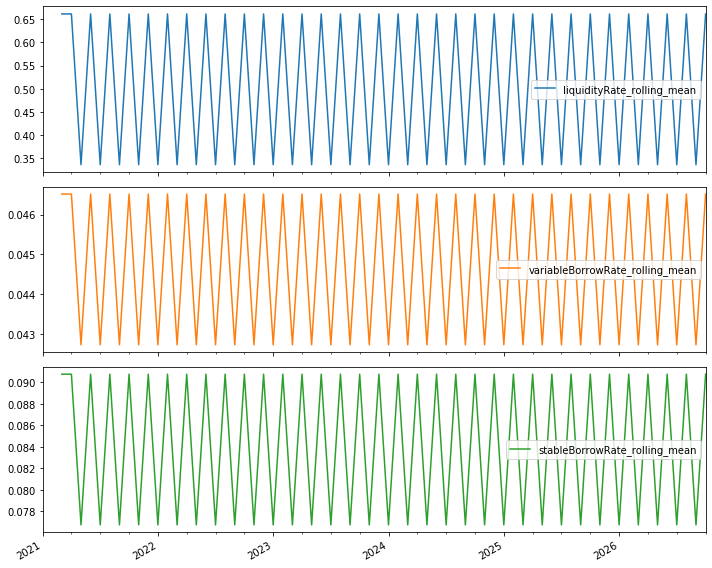

e:\program\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


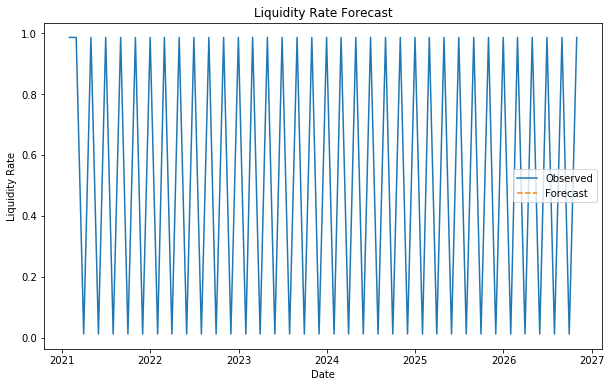

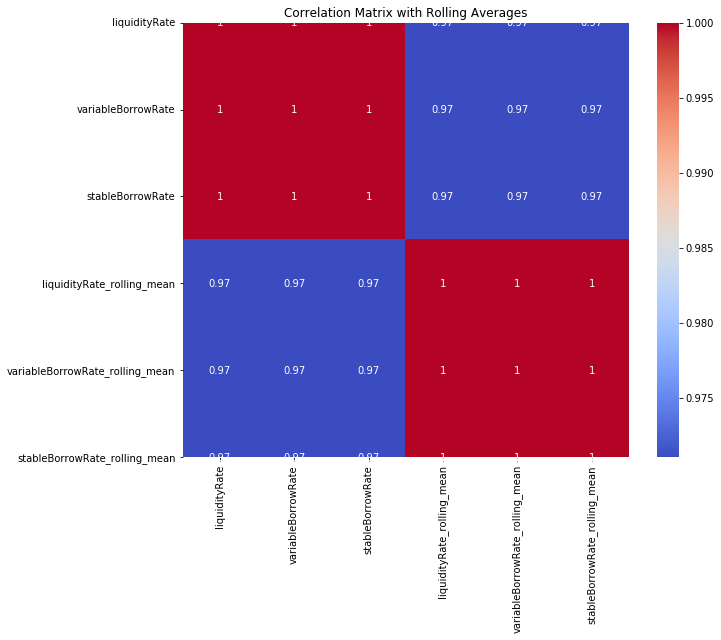

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns

# Load the data
df = pd.read_csv('consolidated_liquidity_data.csv')

# Filter for USD Coin
usd_coin_df = df[df['name'] == 'USD Coin']

# Generate a time index assuming monthly data points
usd_coin_df = usd_coin_df.reset_index(drop=True)
usd_coin_df.index = pd.date_range(start='2021-01-01', periods=len(usd_coin_df), freq='M')

# Select relevant columns for time-series analysis
ts_data = usd_coin_df[['liquidityRate', 'variableBorrowRate', 'stableBorrowRate']]

# Plot the time series data
ts_data.plot(subplots=True, figsize=(10, 8))
plt.tight_layout()
plt.show()

# Calculate rolling averages
usd_coin_df['liquidityRate_rolling_mean'] = usd_coin_df['liquidityRate'].rolling(window=3).mean()
usd_coin_df['variableBorrowRate_rolling_mean'] = usd_coin_df['variableBorrowRate'].rolling(window=3).mean()
usd_coin_df['stableBorrowRate_rolling_mean'] = usd_coin_df['stableBorrowRate'].rolling(window=3).mean()

# Plot rolling averages
usd_coin_df[['liquidityRate_rolling_mean', 'variableBorrowRate_rolling_mean', 'stableBorrowRate_rolling_mean']].plot(subplots=True, figsize=(10, 8))
plt.tight_layout()
plt.show()

# Fit ARIMA model for liquidityRate
model = ARIMA(usd_coin_df['liquidityRate'], order=(1, 1, 1))
model_fit = model.fit()
forecast = model_fit.get_forecast(steps=5)
forecast_index = pd.date_range(start=usd_coin_df.index[-1], periods=6, freq='M')[1:]
forecast_df = pd.DataFrame(forecast.predicted_mean, index=forecast_index, columns=['Forecasted_liquidityRate'])

# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(usd_coin_df.index, usd_coin_df['liquidityRate'], label='Observed')
plt.plot(forecast_df.index, forecast_df['Forecasted_liquidityRate'], label='Forecast', linestyle='--')
plt.title('Liquidity Rate Forecast')
plt.xlabel('Date')
plt.ylabel('Liquidity Rate')
plt.legend()
plt.show()

# Compute the correlation matrix
corr_matrix = usd_coin_df[['liquidityRate', 'variableBorrowRate', 'stableBorrowRate',
                           'liquidityRate_rolling_mean', 'variableBorrowRate_rolling_mean', 'stableBorrowRate_rolling_mean']].corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix with Rolling Averages')
plt.show()


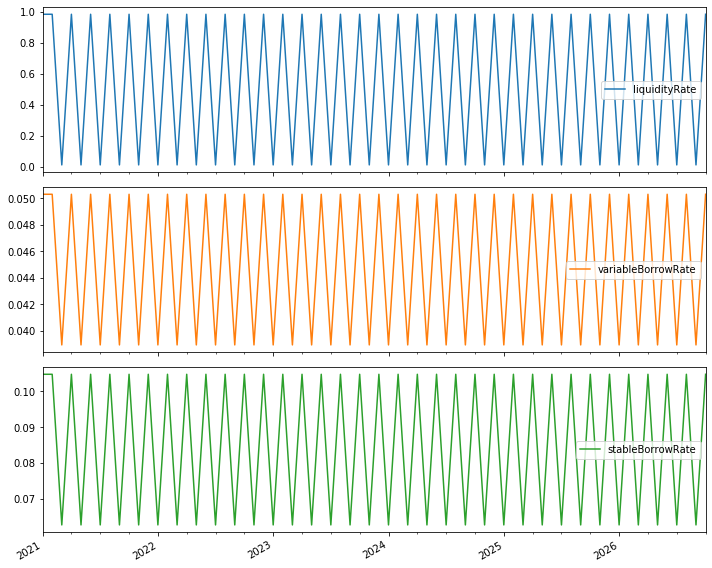

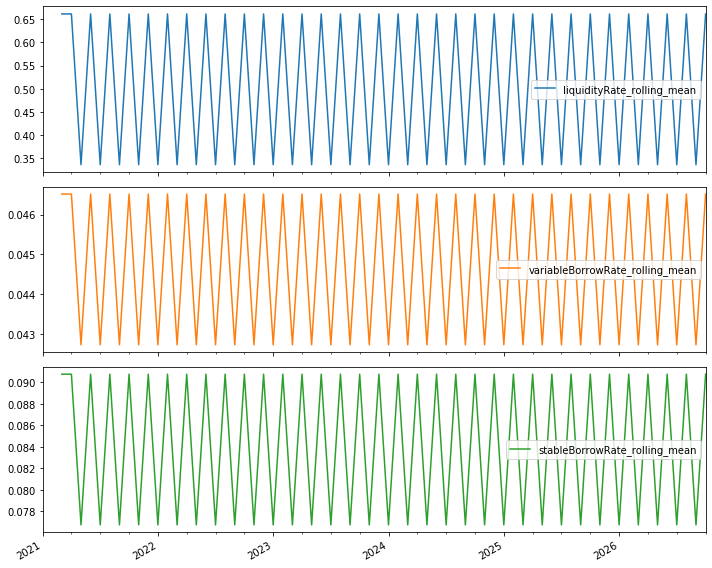

e:\program\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


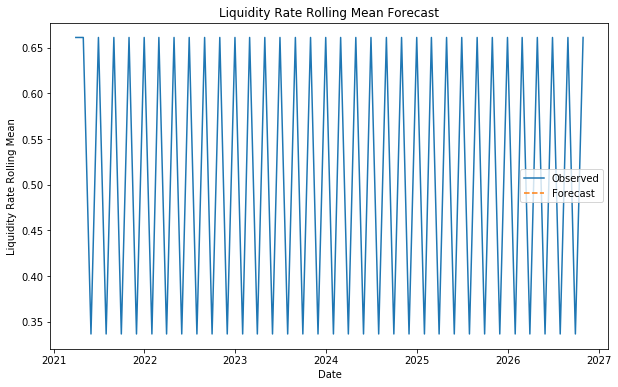

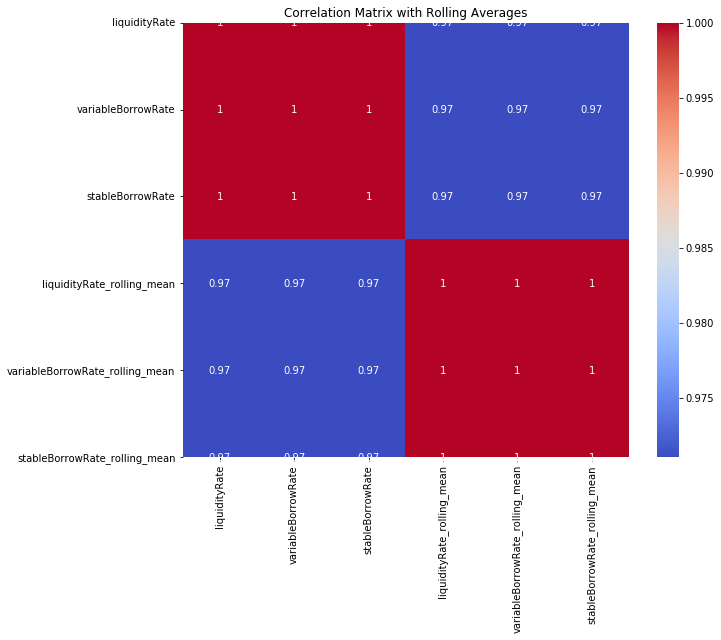

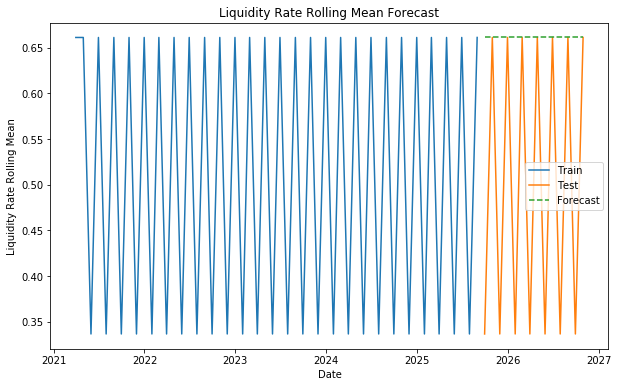

Mean Squared Error: 0.05262346898163258


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Load the data
df = pd.read_csv('consolidated_liquidity_data.csv')

# Filter for USD Coin
usd_coin_df = df[df['name'] == 'USD Coin']

# Generate a time index assuming monthly data points
usd_coin_df = usd_coin_df.reset_index(drop=True)
usd_coin_df.index = pd.date_range(start='2021-01-01', periods=len(usd_coin_df), freq='M')

# Select relevant columns for time-series analysis
ts_data = usd_coin_df[['liquidityRate', 'variableBorrowRate', 'stableBorrowRate']]

# Plot the time series data
ts_data.plot(subplots=True, figsize=(10, 8))
plt.tight_layout()
plt.show()

# Calculate rolling averages
usd_coin_df['liquidityRate_rolling_mean'] = usd_coin_df['liquidityRate'].rolling(window=3).mean()
usd_coin_df['variableBorrowRate_rolling_mean'] = usd_coin_df['variableBorrowRate'].rolling(window=3).mean()
usd_coin_df['stableBorrowRate_rolling_mean'] = usd_coin_df['stableBorrowRate'].rolling(window=3).mean()

# Plot rolling averages
usd_coin_df[['liquidityRate_rolling_mean', 'variableBorrowRate_rolling_mean', 'stableBorrowRate_rolling_mean']].plot(subplots=True, figsize=(10, 8))
plt.tight_layout()
plt.show()

# Fit ARIMA model for liquidityRate with rolling mean
model = ARIMA(usd_coin_df['liquidityRate_rolling_mean'].dropna(), order=(1, 1, 1))
model_fit = model.fit()
forecast = model_fit.get_forecast(steps=5)
forecast_index = pd.date_range(start=usd_coin_df.index[-1], periods=6, freq='M')[1:]
forecast_df = pd.DataFrame(forecast.predicted_mean, index=forecast_index, columns=['Forecasted_liquidityRate'])

# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(usd_coin_df.index, usd_coin_df['liquidityRate_rolling_mean'], label='Observed')
plt.plot(forecast_df.index, forecast_df['Forecasted_liquidityRate'], label='Forecast', linestyle='--')
plt.title('Liquidity Rate Rolling Mean Forecast')
plt.xlabel('Date')
plt.ylabel('Liquidity Rate Rolling Mean')
plt.legend()
plt.show()

# Compute the correlation matrix with rolling means
corr_matrix = usd_coin_df[['liquidityRate', 'variableBorrowRate', 'stableBorrowRate',
                           'liquidityRate_rolling_mean', 'variableBorrowRate_rolling_mean', 'stableBorrowRate_rolling_mean']].corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix with Rolling Averages')
plt.show()

# Train-test split for time series forecasting
train, test = train_test_split(usd_coin_df['liquidityRate_rolling_mean'].dropna(), test_size=0.2, shuffle=False)

# Fit ARIMA model on the training set
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()
forecast = model_fit.forecast(steps=len(test))

# Plot train, test and forecast
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast, label='Forecast', linestyle='--')
plt.title('Liquidity Rate Rolling Mean Forecast')
plt.xlabel('Date')
plt.ylabel('Liquidity Rate Rolling Mean')
plt.legend()
plt.show()

# Calculate and print the mean squared error
mse = mean_squared_error(test, forecast)
print(f'Mean Squared Error: {mse}')


e:\program\lib\site-packages\ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
e:\program\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
e:\program\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_g

Filtered data with rate of change has been processed and saved to filtered_liquidity_data_with_change.csv.


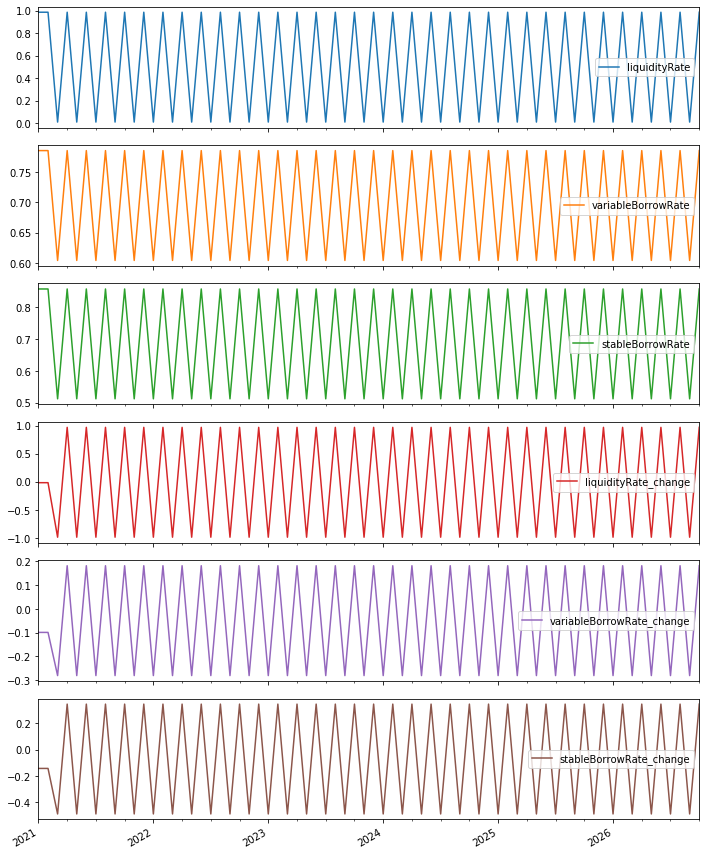

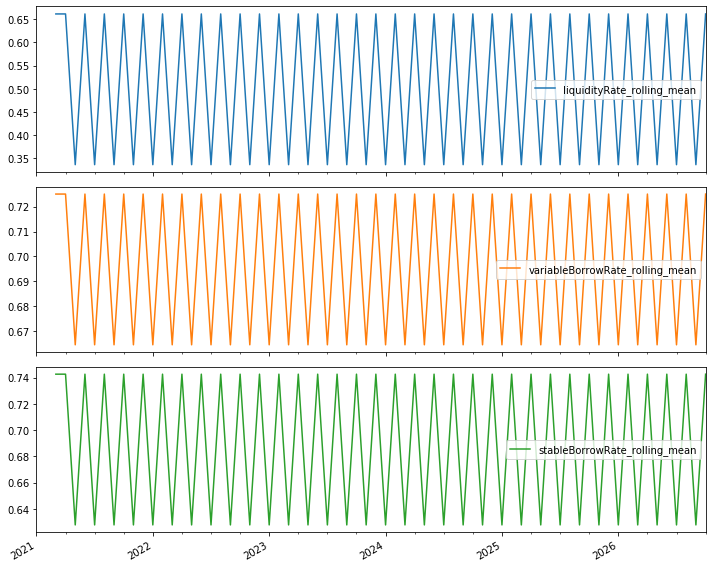

e:\program\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


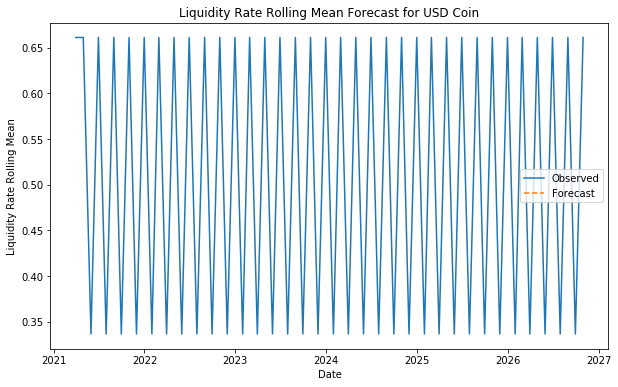

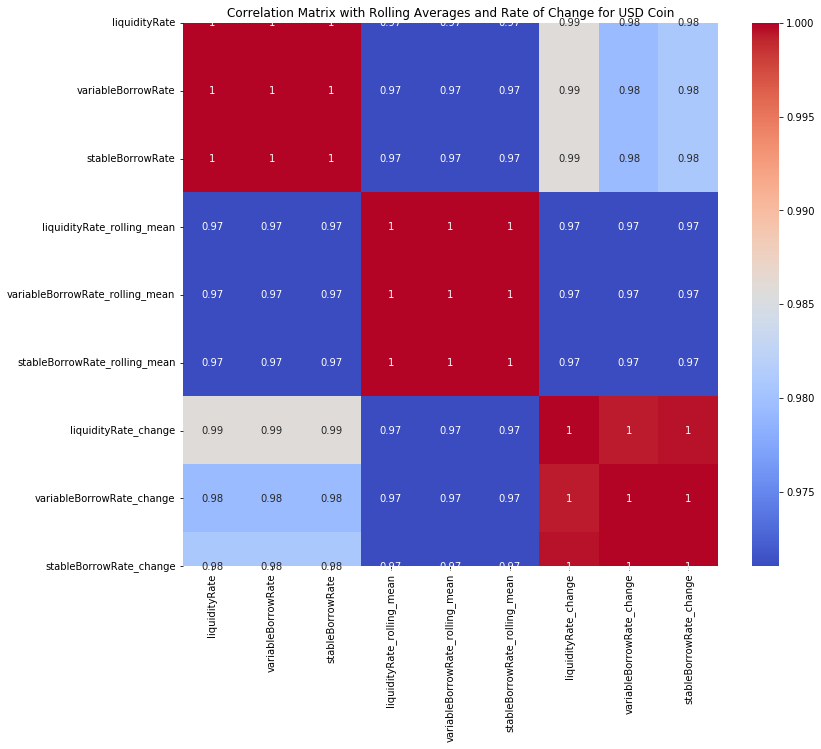

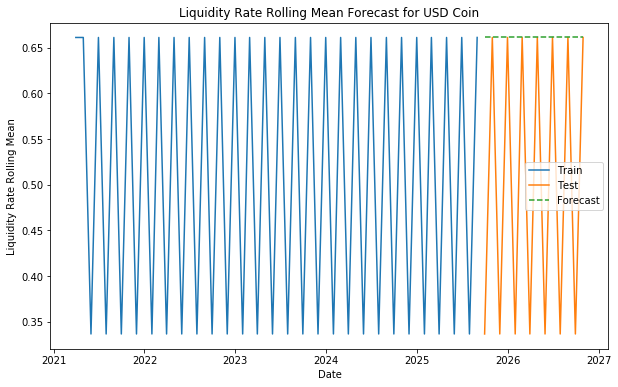

Mean Squared Error for USD Coin: 0.0526235191538385


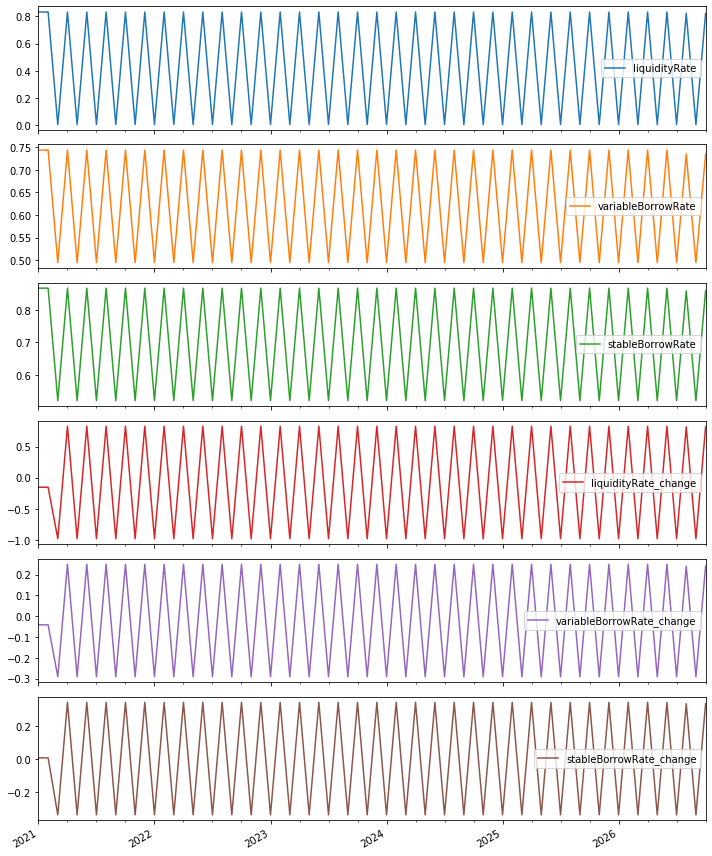

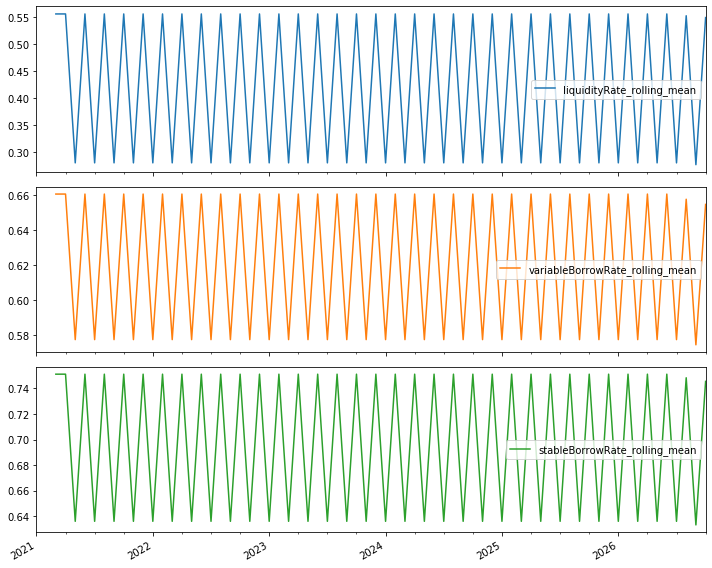

e:\program\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


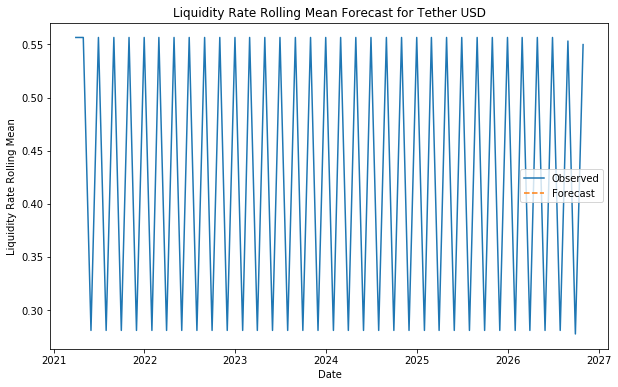

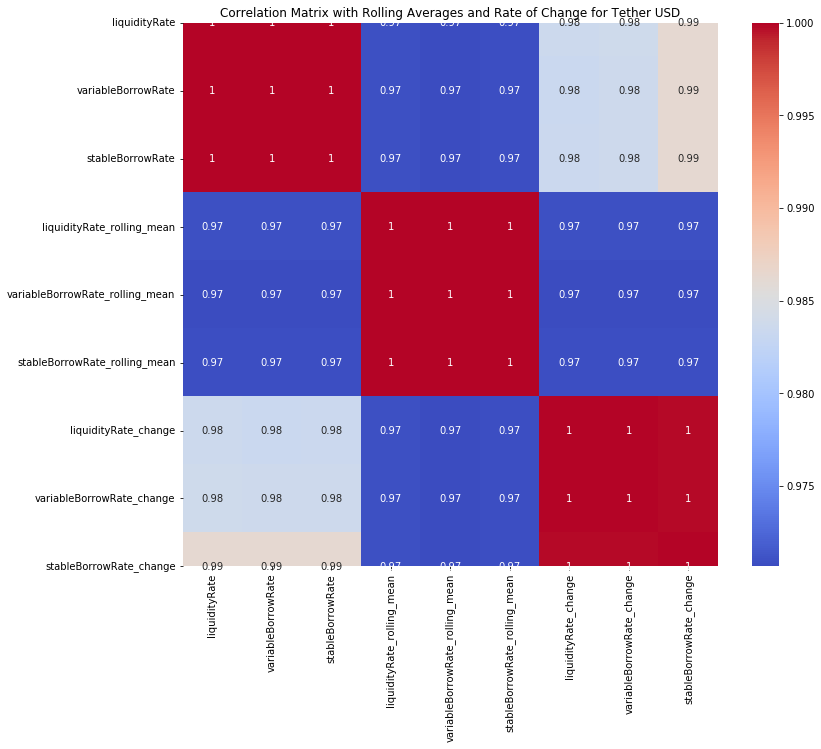

e:\program\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


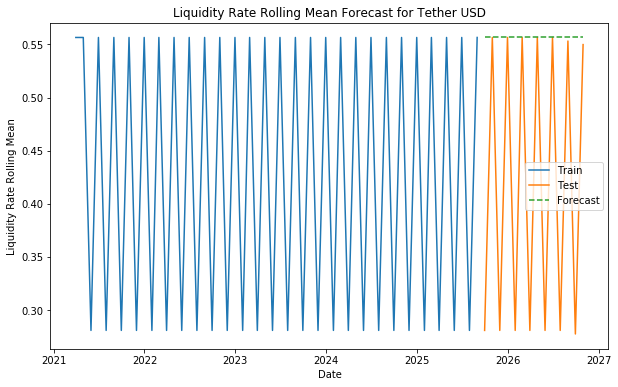

Mean Squared Error for Tether USD: 0.03817428398326135


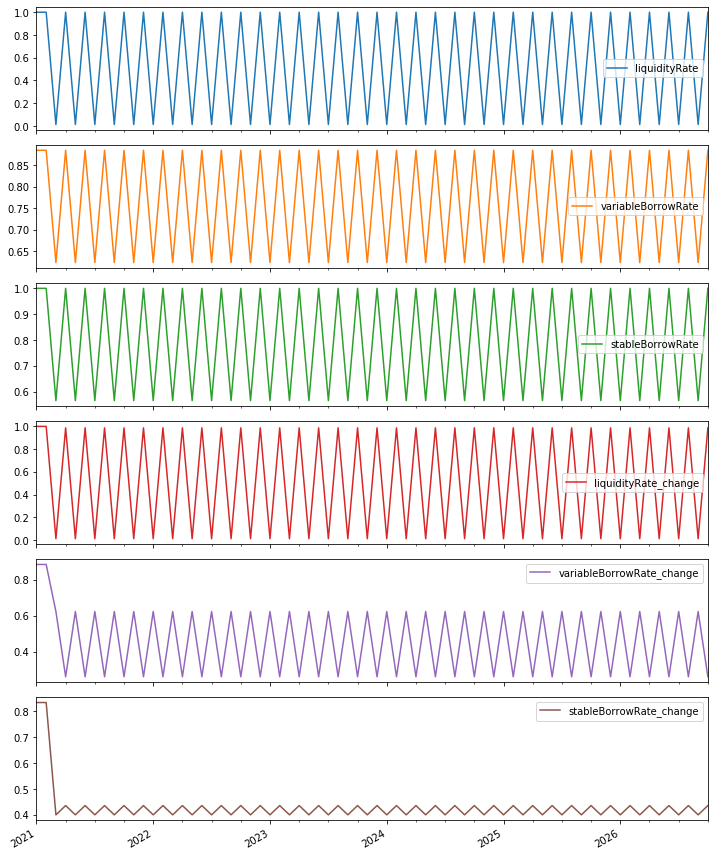

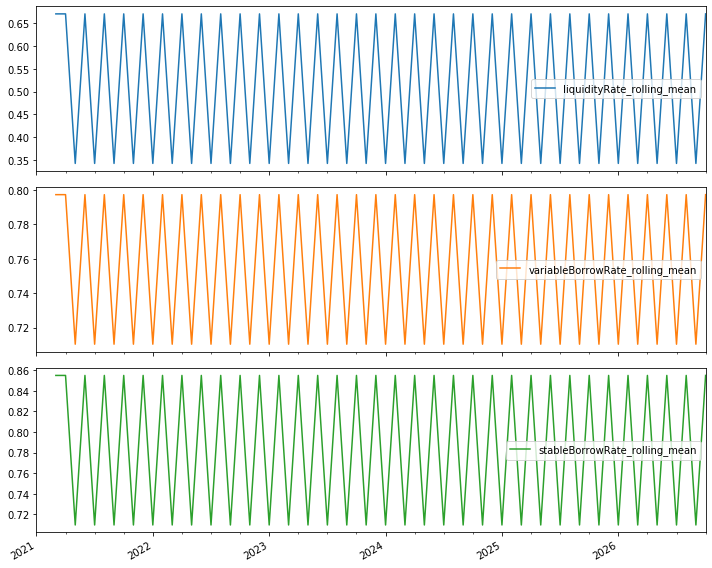

e:\program\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


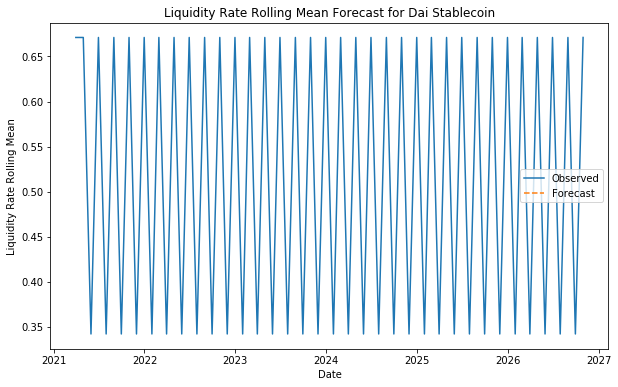

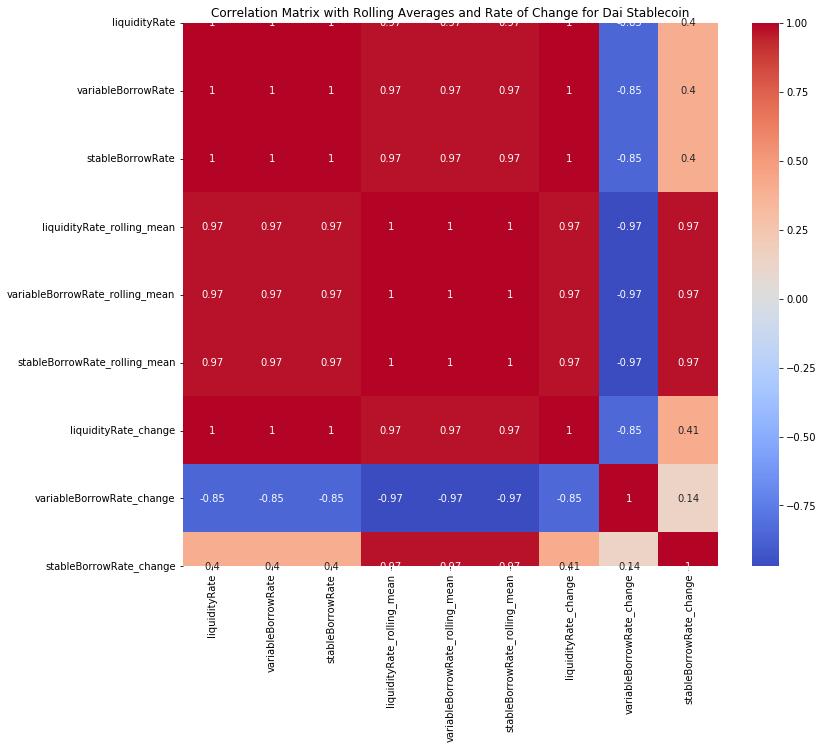

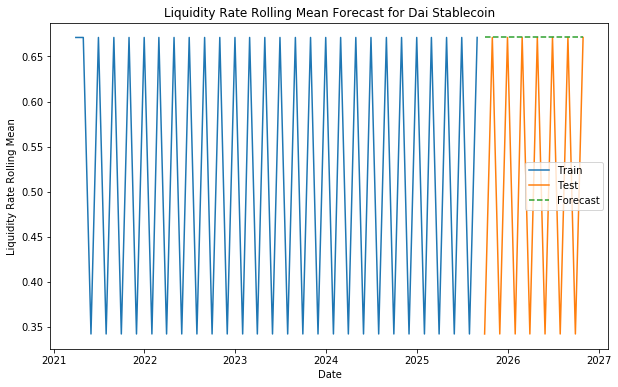

Mean Squared Error for Dai Stablecoin: 0.05410263109615699


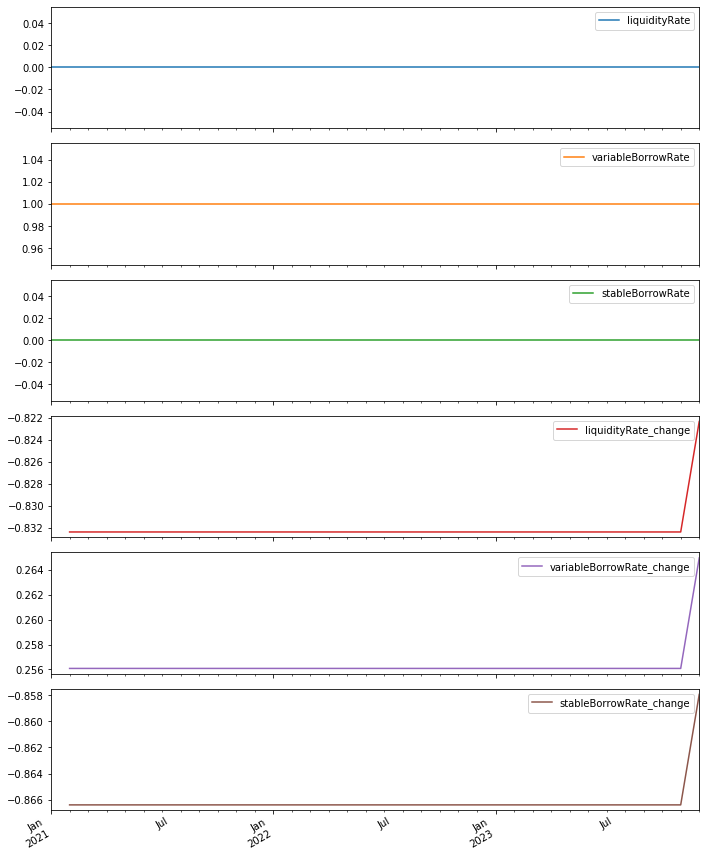

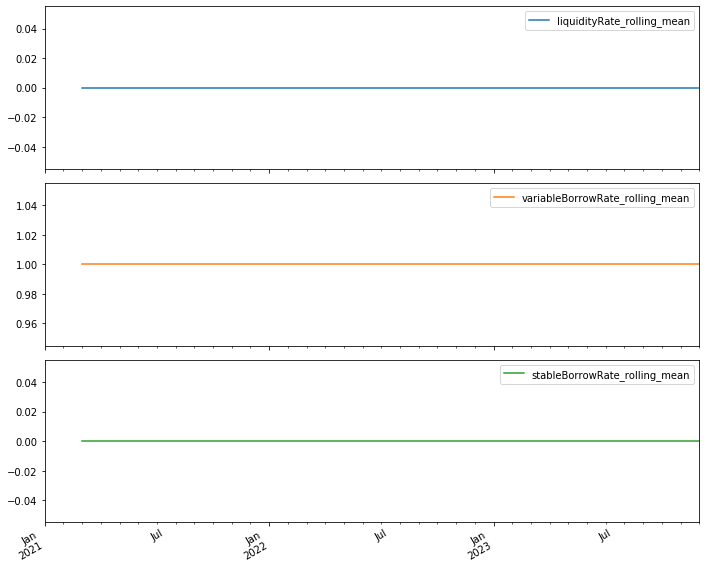

e:\program\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


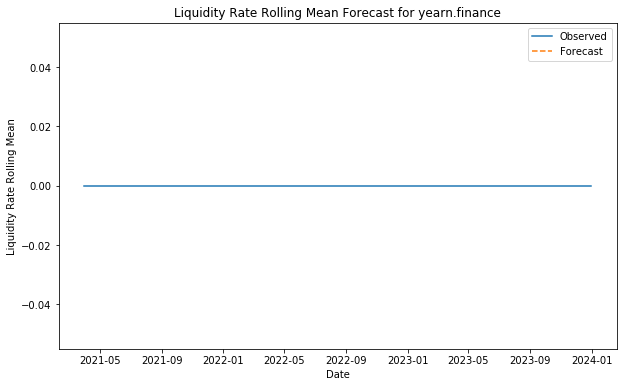

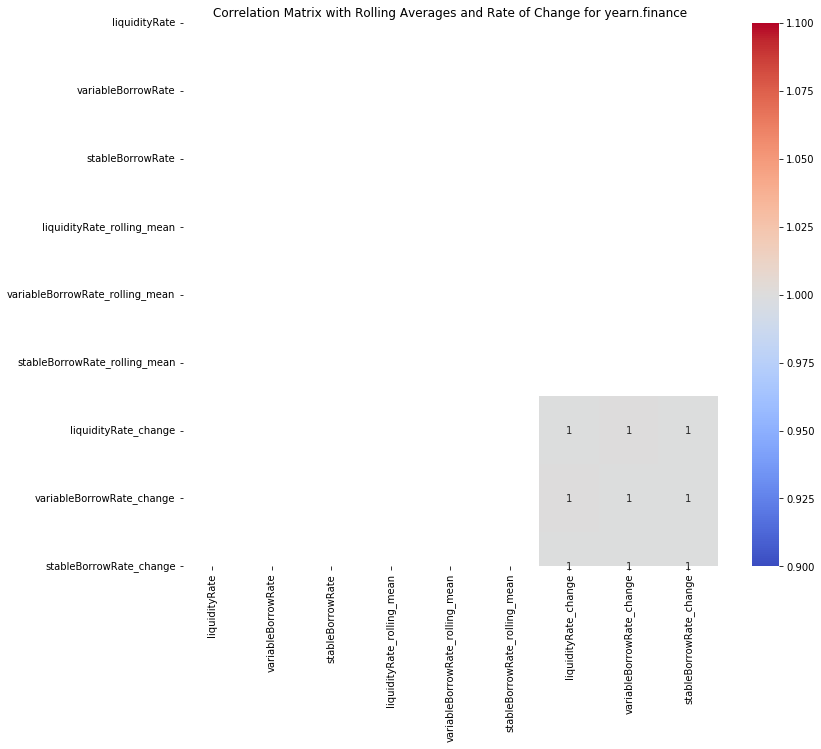

e:\program\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


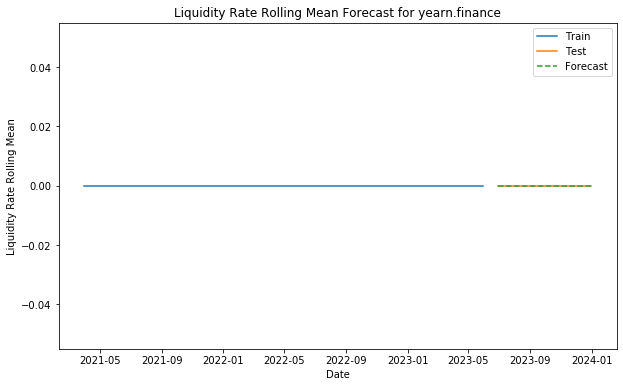

Mean Squared Error for yearn.finance: 0.0


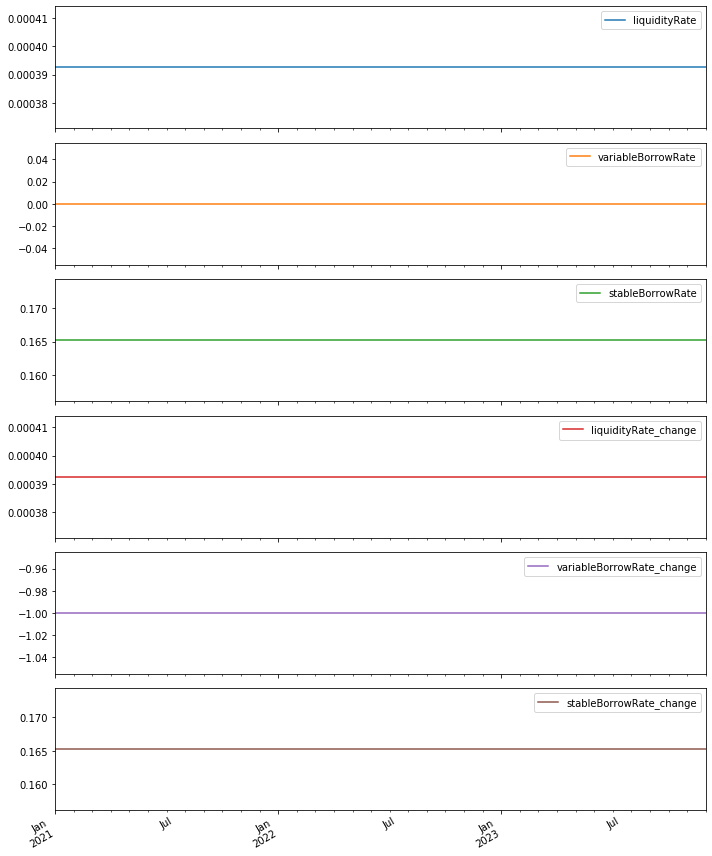

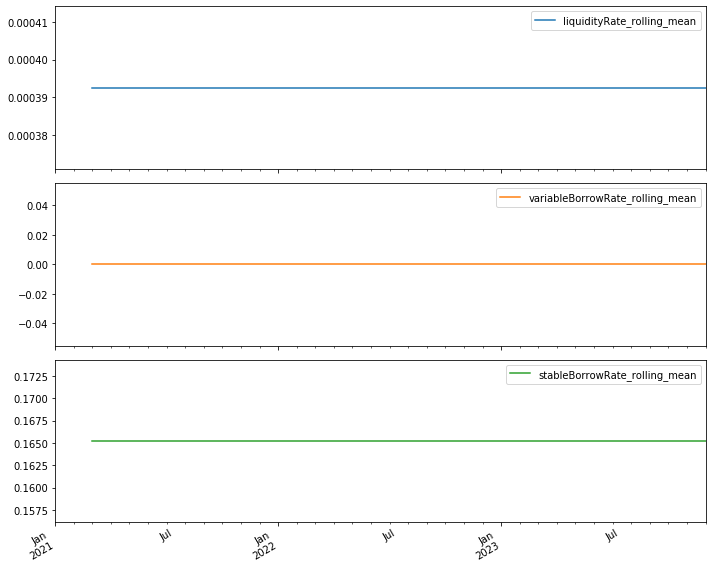

e:\program\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


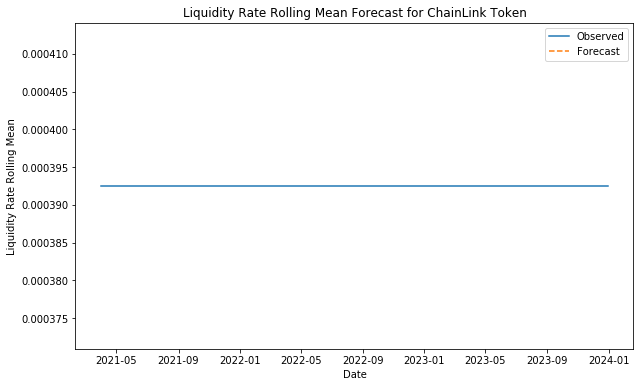

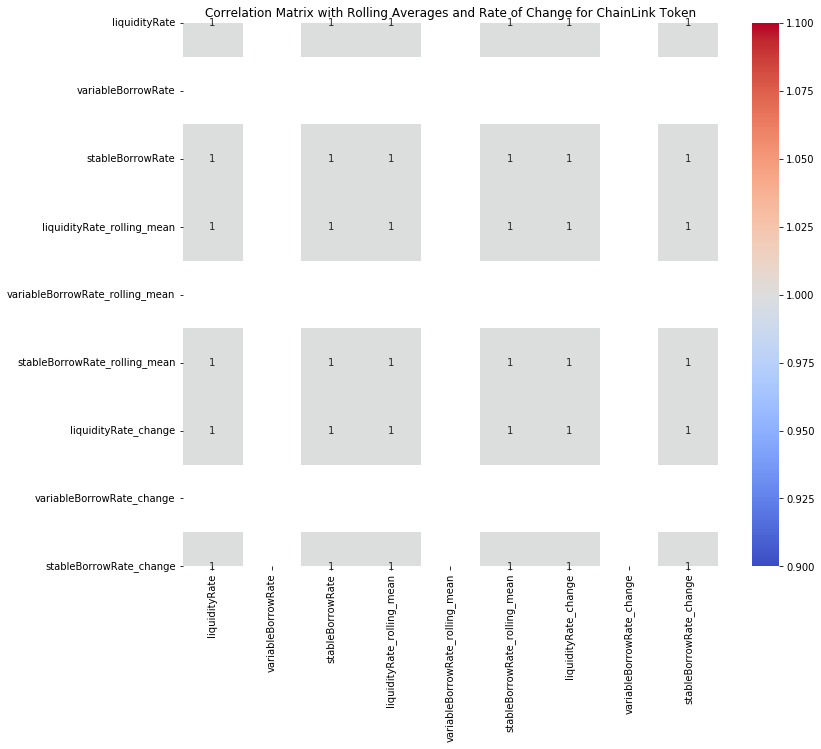

e:\program\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


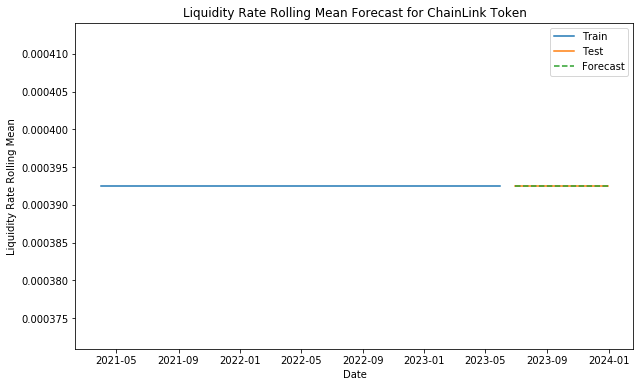

Mean Squared Error for ChainLink Token: 0.0


In [16]:
import pandas as pd
import json
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def load_and_process_json(file_path):
    """Load JSON data and convert it to a DataFrame."""
    with open(file_path, 'r') as file:
        data = json.load(file)

    flattened_data = []
    for month_data in data:
        for reserve in month_data:
            flattened_data.append({
                'name': reserve['name'],
                'liquidityRate': float(reserve['liquidityRate']) / 1e27,
                'variableBorrowRate': float(reserve['variableBorrowRate']) / 1e27,
                'stableBorrowRate': float(reserve['stableBorrowRate']) / 1e27
            })
    return pd.DataFrame(flattened_data)

# Paths to your JSON files
file_paths = ['../data/detailed_reserves_data_2021.json', '../data/detailed_reserves_data_2022.json', '../data/detailed_reserves_data_2023.json']
all_data_frames = [load_and_process_json(path) for path in file_paths]

# Concatenate all yearly data into a single DataFrame
complete_data = pd.concat(all_data_frames, ignore_index=True)

# Filter out the desired assets
assets_of_interest = ['USD Coin', 'Tether USD', 'Dai Stablecoin', 'yearn.finance', 'ChainLink Token']
filtered_data = complete_data[complete_data['name'].isin(assets_of_interest)]

# Optionally, normalize the entire DataFrame
scaler = MinMaxScaler()
filtered_data[['liquidityRate', 'variableBorrowRate', 'stableBorrowRate']] = scaler.fit_transform(
    filtered_data[['liquidityRate', 'variableBorrowRate', 'stableBorrowRate']]
)

# Calculate rate of change (momentum) for each rate
filtered_data['liquidityRate_change'] = filtered_data['liquidityRate'].diff()
filtered_data['variableBorrowRate_change'] = filtered_data['variableBorrowRate'].diff()
filtered_data['stableBorrowRate_change'] = filtered_data['stableBorrowRate'].diff()

# Save the DataFrame to a CSV file
filtered_data.to_csv('../data/filtered_liquidity_data_with_change.csv', index=False)

print("Filtered data with rate of change has been processed and saved to filtered_liquidity_data_with_change.csv.")

# Load the data
df = pd.read_csv('../data/filtered_liquidity_data_with_change.csv')

# Group by asset and perform the same analysis for each asset
for asset in assets_of_interest:
    asset_df = df[df['name'] == asset]

    # Generate a time index assuming monthly data points
    asset_df = asset_df.reset_index(drop=True)
    asset_df.index = pd.date_range(start='2021-01-01', periods=len(asset_df), freq='M')

    # Select relevant columns for time-series analysis
    ts_data = asset_df[['liquidityRate', 'variableBorrowRate', 'stableBorrowRate',
                        'liquidityRate_change', 'variableBorrowRate_change', 'stableBorrowRate_change']]

    # Plot the time series data
    ts_data.plot(subplots=True, figsize=(10, 12))
    plt.tight_layout()
    plt.show()

    # Calculate rolling averages
    asset_df['liquidityRate_rolling_mean'] = asset_df['liquidityRate'].rolling(window=3).mean()
    asset_df['variableBorrowRate_rolling_mean'] = asset_df['variableBorrowRate'].rolling(window=3).mean()
    asset_df['stableBorrowRate_rolling_mean'] = asset_df['stableBorrowRate'].rolling(window=3).mean()

    # Plot rolling averages
    asset_df[['liquidityRate_rolling_mean', 'variableBorrowRate_rolling_mean', 'stableBorrowRate_rolling_mean']].plot(subplots=True, figsize=(10, 8))
    plt.tight_layout()
    plt.show()

    # Fit ARIMA model for liquidityRate with rolling mean
    model = ARIMA(asset_df['liquidityRate_rolling_mean'].dropna(), order=(1, 1, 1))
    model_fit = model.fit()
    forecast = model_fit.get_forecast(steps=5)
    forecast_index = pd.date_range(start=asset_df.index[-1], periods=6, freq='M')[1:]
    forecast_df = pd.DataFrame(forecast.predicted_mean, index=forecast_index, columns=['Forecasted_liquidityRate'])

    # Plot the forecast
    plt.figure(figsize=(10, 6))
    plt.plot(asset_df.index, asset_df['liquidityRate_rolling_mean'], label='Observed')
    plt.plot(forecast_df.index, forecast_df['Forecasted_liquidityRate'], label='Forecast', linestyle='--')
    plt.title(f'Liquidity Rate Rolling Mean Forecast for {asset}')
    plt.xlabel('Date')
    plt.ylabel('Liquidity Rate Rolling Mean')
    plt.legend()
    plt.show()

    # Compute the correlation matrix with rolling means and rate of change
    corr_matrix = asset_df[['liquidityRate', 'variableBorrowRate', 'stableBorrowRate',
                            'liquidityRate_rolling_mean', 'variableBorrowRate_rolling_mean', 'stableBorrowRate_rolling_mean',
                            'liquidityRate_change', 'variableBorrowRate_change', 'stableBorrowRate_change']].corr()

    # Plot the correlation matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    plt.title(f'Correlation Matrix with Rolling Averages and Rate of Change for {asset}')
    plt.show()

    # Train-test split for time series forecasting
    train, test = train_test_split(asset_df['liquidityRate_rolling_mean'].dropna(), test_size=0.2, shuffle=False)

    # Fit ARIMA model on the training set
    model = ARIMA(train, order=(1, 1, 1))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(test))

    # Plot train, test and forecast
    plt.figure(figsize=(10, 6))
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Test')
    plt.plot(test.index, forecast, label='Forecast', linestyle='--')
    plt.title(f'Liquidity Rate Rolling Mean Forecast for {asset}')
    plt.xlabel('Date')
    plt.ylabel('Liquidity Rate Rolling Mean')
    plt.legend()
    plt.show()

    # Calculate and print the mean squared error
    mse = mean_squared_error(test, forecast)
    print(f'Mean Squared Error for {asset}: {mse}')


In [18]:
import pandas as pd
import json
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

def load_and_process_json(file_path):
    """Load JSON data and convert it to a DataFrame."""
    with open(file_path, 'r') as file:
        data = json.load(file)

    flattened_data = []
    for month_data in data:
        for reserve in month_data:
            flattened_data.append({
                'name': reserve['name'],
                'liquidityRate': float(reserve['liquidityRate']) / 1e27,
                'variableBorrowRate': float(reserve['variableBorrowRate']) / 1e27,
                'stableBorrowRate': float(reserve['stableBorrowRate']) / 1e27
            })
    return pd.DataFrame(flattened_data)

# Paths to your JSON files
file_paths = ['../data/detailed_reserves_data_2021.json', '../data/detailed_reserves_data_2022.json', '../data/detailed_reserves_data_2023.json']
all_data_frames = [load_and_process_json(path) for path in file_paths]

# Concatenate all yearly data into a single DataFrame
complete_data = pd.concat(all_data_frames, ignore_index=True)

# Filter out the desired assets
assets_of_interest = ['USD Coin', 'Tether USD', 'Dai Stablecoin']
filtered_data = complete_data[complete_data['name'].isin(assets_of_interest)]

# Optionally, normalize the entire DataFrame
scaler = MinMaxScaler()
filtered_data[['liquidityRate', 'variableBorrowRate', 'stableBorrowRate']] = scaler.fit_transform(
    filtered_data[['liquidityRate', 'variableBorrowRate', 'stableBorrowRate']]
)

# Calculate rate of change (momentum) for each rate
filtered_data['liquidityRate_change'] = filtered_data['liquidityRate'].diff()
filtered_data['variableBorrowRate_change'] = filtered_data['variableBorrowRate'].diff()
filtered_data['stableBorrowRate_change'] = filtered_data['stableBorrowRate'].diff()

# Save the DataFrame to a CSV file
filtered_data.to_csv('../data/filtered_liquidity_data_with_change.csv', index=False)

print("Filtered data with rate of change has been processed and saved to filtered_liquidity_data_with_change.csv.")

# Load the data
df = pd.read_csv('../data/filtered_liquidity_data_with_change.csv')

# Check for multicollinearity using VIF
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]
    return vif_data

# Group by asset and perform the same analysis for each asset
for asset in assets_of_interest:
    asset_df = df[df['name'] == asset]

    # Select relevant columns for VIF analysis
    vif_data = calculate_vif(asset_df[['liquidityRate', 'variableBorrowRate', 'stableBorrowRate',
                                        'liquidityRate_change', 'variableBorrowRate_change', 'stableBorrowRate_change']].dropna())
    print(f"VIF for {asset}:")
    print(vif_data)


Filtered data with rate of change has been processed and saved to filtered_liquidity_data_with_change.csv.
VIF for USD Coin:
                     feature  VIF
0              liquidityRate  inf
1         variableBorrowRate  inf
2           stableBorrowRate  inf
3       liquidityRate_change  inf
4  variableBorrowRate_change  inf
5    stableBorrowRate_change  inf
VIF for Tether USD:
                     feature           VIF
0              liquidityRate           inf
1         variableBorrowRate           inf
2           stableBorrowRate  3.785503e+04
3       liquidityRate_change           inf
4  variableBorrowRate_change           inf
5    stableBorrowRate_change           inf
VIF for Dai Stablecoin:
                     feature  VIF
0              liquidityRate  inf
1         variableBorrowRate  inf
2           stableBorrowRate  inf
3       liquidityRate_change  inf
4  variableBorrowRate_change  inf
5    stableBorrowRate_change  inf


e:\program\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
e:\program\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
e:\program\lib\site-packages\ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_g

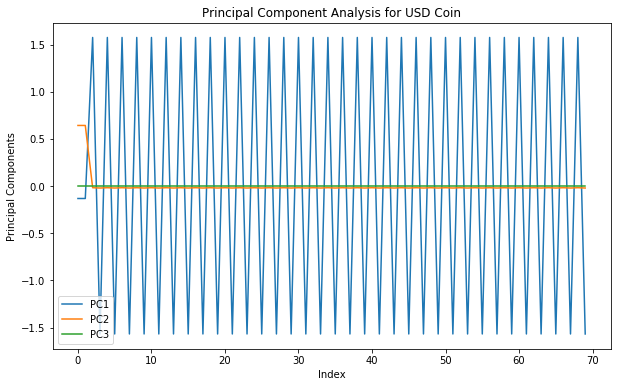

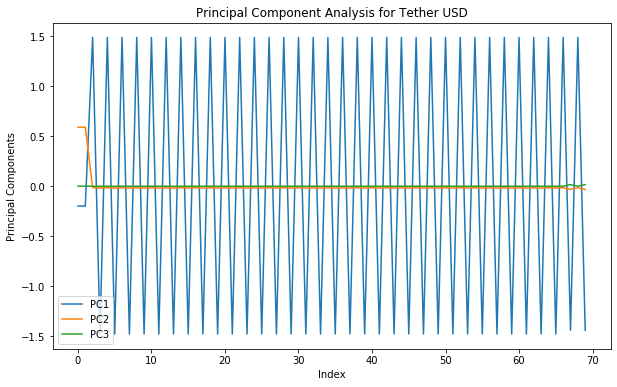

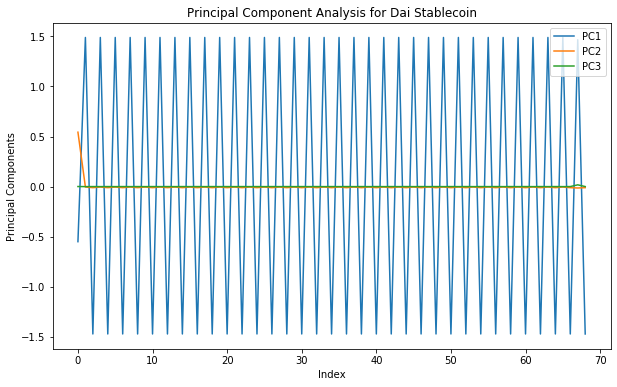

In [19]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Perform PCA for dimensionality reduction
def perform_pca(df, n_components=3):
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(df.dropna())
    pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(n_components)])
    return pca_df, pca

# Group by asset and perform PCA analysis for each asset
for asset in assets_of_interest:
    asset_df = df[df['name'] == asset]

    # Select relevant columns for PCA
    pca_df, pca_model = perform_pca(asset_df[['liquidityRate', 'variableBorrowRate', 'stableBorrowRate',
                                              'liquidityRate_change', 'variableBorrowRate_change', 'stableBorrowRate_change']])
    
    # Plot PCA results
    plt.figure(figsize=(10, 6))
    plt.plot(pca_df.index, pca_df['PC1'], label='PC1')
    plt.plot(pca_df.index, pca_df['PC2'], label='PC2')
    plt.plot(pca_df.index, pca_df['PC3'], label='PC3')
    plt.title(f'Principal Component Analysis for {asset}')
    plt.xlabel('Index')
    plt.ylabel('Principal Components')
    plt.legend()
    plt.show()


e:\program\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
e:\program\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Filtered data with rate of change has been processed and saved to filtered_liquidity_data_with_change.csv.


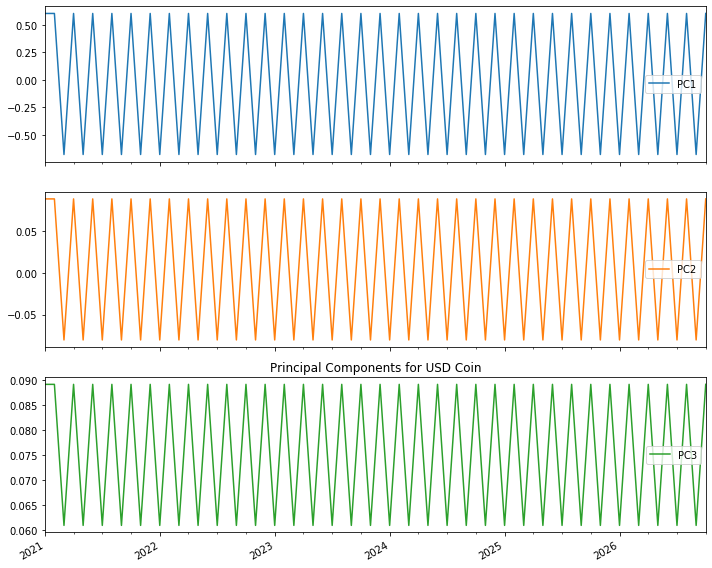

e:\program\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


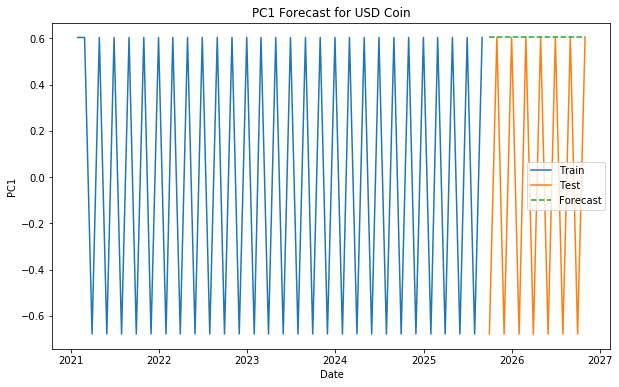

Mean Squared Error for USD Coin: 0.8225182095880378


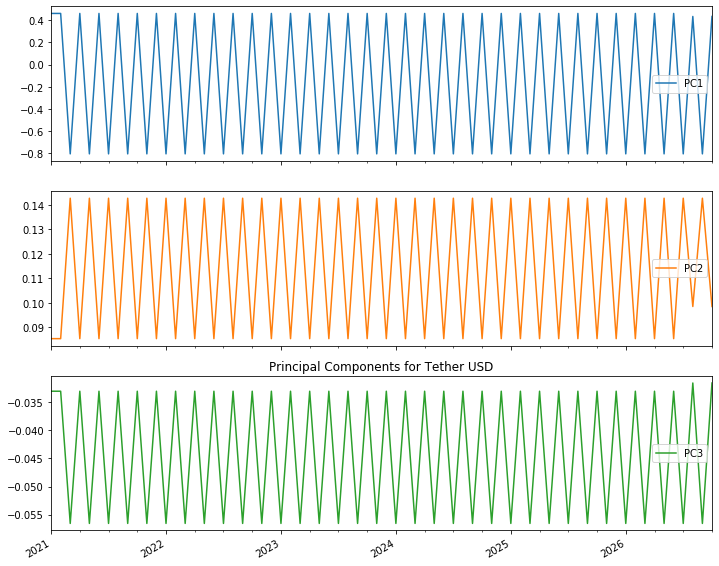

e:\program\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


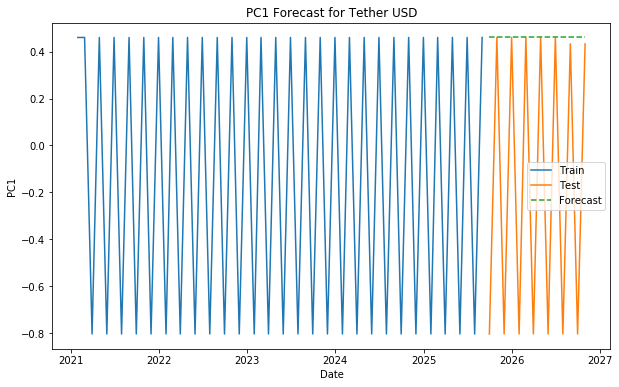

Mean Squared Error for Tether USD: 0.8000031538621936


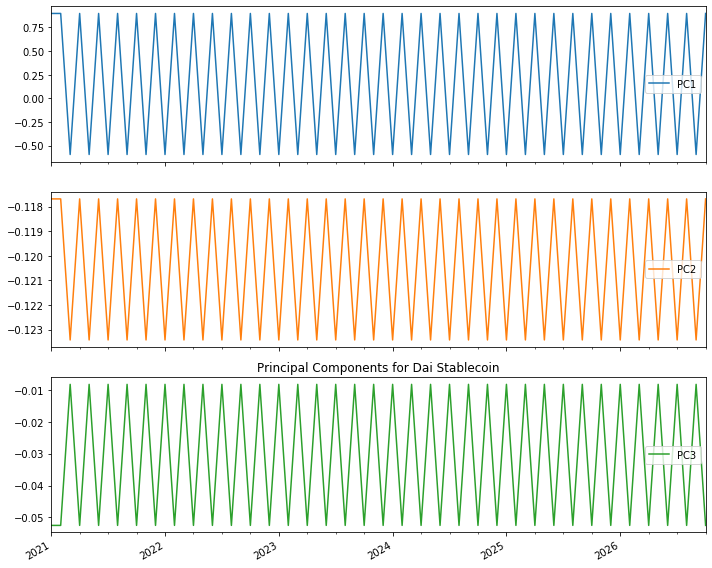

e:\program\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


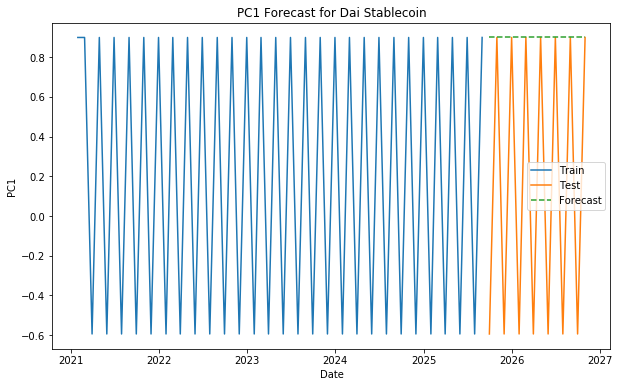

Mean Squared Error for Dai Stablecoin: 1.1140251977410445


In [22]:
import pandas as pd
import json
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns

def load_and_process_json(file_path):
    """Load JSON data and convert it to a DataFrame."""
    with open(file_path, 'r') as file:
        data = json.load(file)

    flattened_data = []
    for month_data in data:
        for reserve in month_data:
            flattened_data.append({
                'name': reserve['name'],
                'liquidityRate': float(reserve['liquidityRate']) / 1e27,
                'variableBorrowRate': float(reserve['variableBorrowRate']) / 1e27,
                'stableBorrowRate': float(reserve['stableBorrowRate']) / 1e27
            })
    return pd.DataFrame(flattened_data)

# Paths to your JSON files
file_paths = ['../data/detailed_reserves_data_2021.json', '../data/detailed_reserves_data_2022.json', '../data/detailed_reserves_data_2023.json']
all_data_frames = [load_and_process_json(path) for path in file_paths]

# Concatenate all yearly data into a single DataFrame
complete_data = pd.concat(all_data_frames, ignore_index=True)

# Filter out the desired assets
assets_of_interest = ['USD Coin', 'Tether USD', 'Dai Stablecoin']
filtered_data = complete_data[complete_data['name'].isin(assets_of_interest)]

# Optionally, normalize the entire DataFrame
scaler = MinMaxScaler()
filtered_data[['liquidityRate', 'variableBorrowRate', 'stableBorrowRate']] = scaler.fit_transform(
    filtered_data[['liquidityRate', 'variableBorrowRate', 'stableBorrowRate']]
)

# Save the DataFrame to a CSV file
filtered_data.to_csv('../data/filtered_liquidity_data_with_change.csv', index=False)

print("Filtered data with rate of change has been processed and saved to filtered_liquidity_data_with_change.csv.")

# Load the data
df = pd.read_csv('../data/filtered_liquidity_data_with_change.csv')

# Perform PCA
pca = PCA(n_components=3)
principal_components = pca.fit_transform(df[['liquidityRate', 'variableBorrowRate', 'stableBorrowRate']])

# Add principal components to DataFrame
df['PC1'] = principal_components[:, 0]
df['PC2'] = principal_components[:, 1]
df['PC3'] = principal_components[:, 2]

# Group by asset and perform the same analysis for each asset
for asset in assets_of_interest:
    asset_df = df[df['name'] == asset]

    # Generate a time index assuming monthly data points
    asset_df = asset_df.reset_index(drop=True)
    asset_df.index = pd.date_range(start='2021-01-01', periods=len(asset_df), freq='M')

    # Plot the principal components
    asset_df[['PC1', 'PC2', 'PC3']].plot(subplots=True, figsize=(10, 8))
    plt.title(f'Principal Components for {asset}')
    plt.tight_layout()
    plt.show()

    # Train-test split for time series forecasting with PC1
    train, test = train_test_split(asset_df['PC1'].dropna(), test_size=0.2, shuffle=False)

    # Fit ARIMA model on the training set
    model = ARIMA(train, order=(1, 1, 1))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(test))

    # Plot train, test and forecast
    plt.figure(figsize=(10, 6))
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Test')
    plt.plot(test.index, forecast, label='Forecast', linestyle='--')
    plt.title(f'PC1 Forecast for {asset}')
    plt.xlabel('Date')
    plt.ylabel('PC1')
    plt.legend()
    plt.show()

    # Calculate and print the mean squared error
    mse = mean_squared_error(test, forecast)
    print(f'Mean Squared Error for {asset}: {mse}')


In [24]:
###Grid Search ARIMA

Best ARIMA parameters for USD Coin: (1, 0, 0)


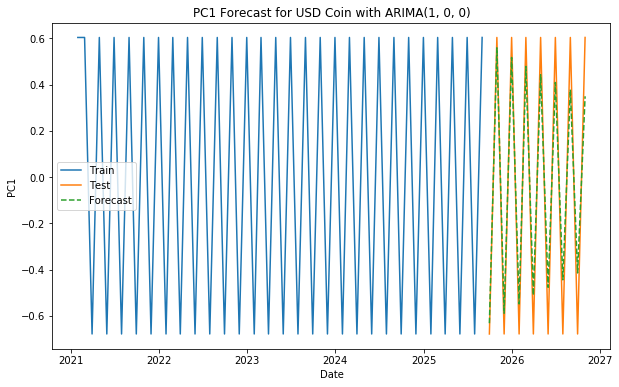

Mean Squared Error for USD Coin with ARIMA(1, 0, 0): 0.03037435883015816
Best ARIMA parameters for Tether USD: (1, 0, 0)


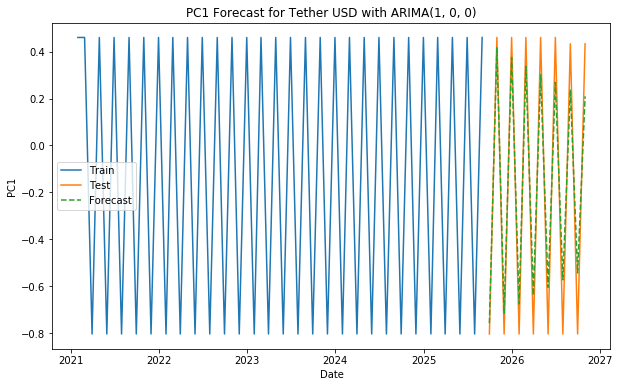

Mean Squared Error for Tether USD with ARIMA(1, 0, 0): 0.027799085442754837
Best ARIMA parameters for Dai Stablecoin: (1, 0, 0)


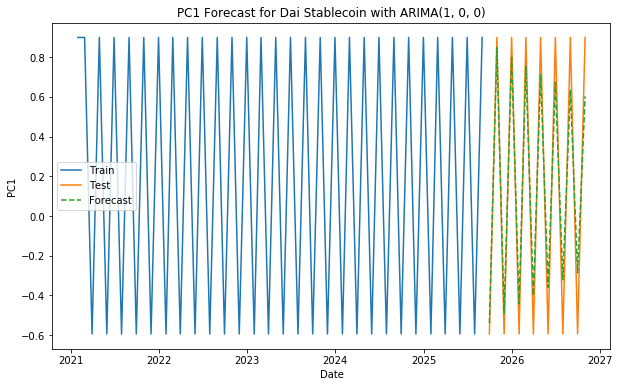

Mean Squared Error for Dai Stablecoin with ARIMA(1, 0, 0): 0.04113950307952472


In [25]:
import itertools
import warnings
from statsmodels.tsa.arima.model import ARIMA

def grid_search_arima(train):
    p = d = q = range(0, 3)
    pdq = list(itertools.product(p, d, q))
    best_aic = float("inf")
    best_pdq = None
    best_model = None
    
    warnings.filterwarnings("ignore")
    
    for param in pdq:
        try:
            model = ARIMA(train, order=param)
            model_fit = model.fit()
            if model_fit.aic < best_aic:
                best_aic = model_fit.aic
                best_pdq = param
                best_model = model_fit
        except:
            continue
    
    return best_model, best_pdq

# Group by asset and perform the same analysis for each asset
for asset in assets_of_interest:
    asset_df = df[df['name'] == asset]

    # Generate a time index assuming monthly data points
    asset_df = asset_df.reset_index(drop=True)
    asset_df.index = pd.date_range(start='2021-01-01', periods=len(asset_df), freq='M')

    # Train-test split for time series forecasting with PC1
    train, test = train_test_split(asset_df['PC1'].dropna(), test_size=0.2, shuffle=False)

    # Grid search for best ARIMA parameters
    best_model, best_pdq = grid_search_arima(train)
    print(f'Best ARIMA parameters for {asset}: {best_pdq}')
    
    # Forecast using the best model
    forecast = best_model.forecast(steps=len(test))

    # Plot train, test, and forecast
    plt.figure(figsize=(10, 6))
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Test')
    plt.plot(test.index, forecast, label='Forecast', linestyle='--')
    plt.title(f'PC1 Forecast for {asset} with ARIMA{best_pdq}')
    plt.xlabel('Date')
    plt.ylabel('PC1')
    plt.legend()
    plt.show()

    # Calculate and print the mean squared error
    mse = mean_squared_error(test, forecast)
    print(f'Mean Squared Error for {asset} with ARIMA{best_pdq}: {mse}')


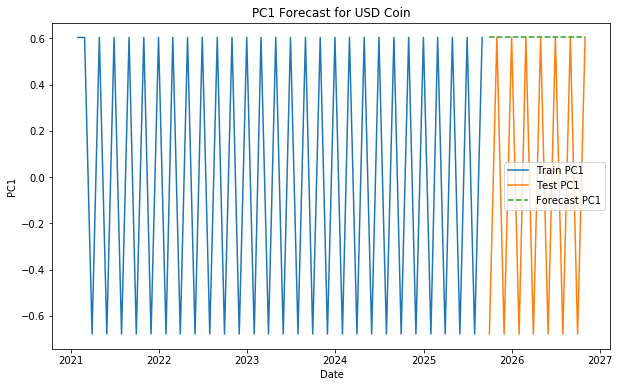

Mean Squared Error for PC1 of USD Coin: 0.8225182095880378


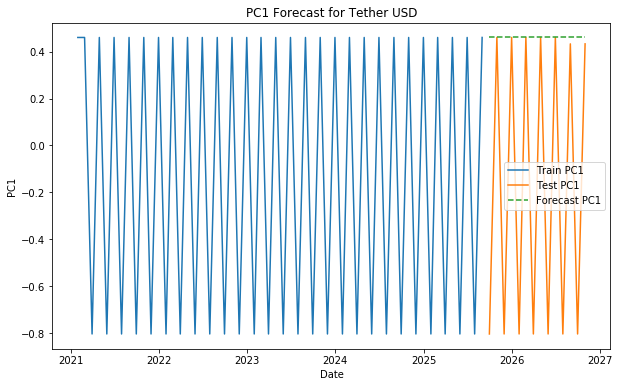

Mean Squared Error for PC1 of Tether USD: 0.8000031538621936


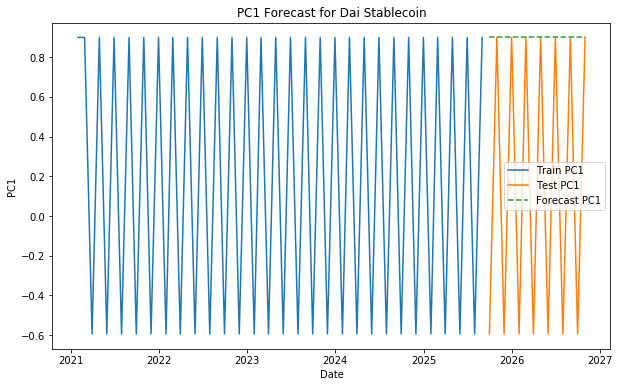

Mean Squared Error for PC1 of Dai Stablecoin: 1.1140251977410445


In [26]:
# Group by asset and perform the same analysis for each asset
for asset in assets_of_interest:
    asset_df = df[df['name'] == asset]

    # Generate a time index assuming monthly data points
    asset_df = asset_df.reset_index(drop=True)
    asset_df.index = pd.date_range(start='2021-01-01', periods=len(asset_df), freq='M')

    # Train-test split for time series forecasting with multiple PCs
    train, test = train_test_split(asset_df[['PC1', 'PC2', 'PC3']].dropna(), test_size=0.2, shuffle=False)

    # Fit ARIMA model on the first principal component
    model_pc1 = ARIMA(train['PC1'], order=(1, 1, 1))
    model_pc1_fit = model_pc1.fit()
    forecast_pc1 = model_pc1_fit.forecast(steps=len(test))

    # Fit ARIMA model on the second principal component
    model_pc2 = ARIMA(train['PC2'], order=(1, 1, 1))
    model_pc2_fit = model_pc2.fit()
    forecast_pc2 = model_pc2_fit.forecast(steps=len(test))

    # Fit ARIMA model on the third principal component
    model_pc3 = ARIMA(train['PC3'], order=(1, 1, 1))
    model_pc3_fit = model_pc3.fit()
    forecast_pc3 = model_pc3_fit.forecast(steps=len(test))

    # Combine forecasts
    combined_forecast = pd.DataFrame({'PC1': forecast_pc1, 'PC2': forecast_pc2, 'PC3': forecast_pc3}, index=test.index)

    # Plot train, test, and forecast for PC1
    plt.figure(figsize=(10, 6))
    plt.plot(train.index, train['PC1'], label='Train PC1')
    plt.plot(test.index, test['PC1'], label='Test PC1')
    plt.plot(test.index, forecast_pc1, label='Forecast PC1', linestyle='--')
    plt.title(f'PC1 Forecast for {asset}')
    plt.xlabel('Date')
    plt.ylabel('PC1')
    plt.legend()
    plt.show()

    # Calculate and print the mean squared error for PC1
    mse_pc1 = mean_squared_error(test['PC1'], forecast_pc1)
    print(f'Mean Squared Error for PC1 of {asset}: {mse_pc1}')
    
    # Repeat the plotting and MSE calculation for PC2 and PC3 as well if needed


## Load and Process Data

In [27]:
import pandas as pd
import json
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import itertools
import warnings

def load_and_process_json(file_path):
    """Load JSON data and convert it to a DataFrame."""
    with open(file_path, 'r') as file:
        data = json.load(file)

    flattened_data = []
    for month_data in data:
        for reserve in month_data:
            flattened_data.append({
                'name': reserve['name'],
                'liquidityRate': float(reserve['liquidityRate']) / 1e27,
                'variableBorrowRate': float(reserve['variableBorrowRate']) / 1e27,
                'stableBorrowRate': float(reserve['stableBorrowRate']) / 1e27
            })
    return pd.DataFrame(flattened_data)

# Paths to your JSON files
file_paths = ['../data/detailed_reserves_data_2021.json', '../data/detailed_reserves_data_2022.json', '../data/detailed_reserves_data_2023.json']
all_data_frames = [load_and_process_json(path) for path in file_paths]

# Concatenate all yearly data into a single DataFrame
complete_data = pd.concat(all_data_frames, ignore_index=True)

# Filter out the desired assets
assets_of_interest = ['USD Coin', 'Tether USD', 'Dai Stablecoin']
filtered_data = complete_data[complete_data['name'].isin(assets_of_interest)]

# Optionally, normalize the entire DataFrame
scaler = MinMaxScaler()
filtered_data[['liquidityRate', 'variableBorrowRate', 'stableBorrowRate']] = scaler.fit_transform(
    filtered_data[['liquidityRate', 'variableBorrowRate', 'stableBorrowRate']]
)

# Save the DataFrame to a CSV file
filtered_data.to_csv('../data/filtered_liquidity_data.csv', index=False)

print("Filtered data has been processed and saved to filtered_liquidity_data.csv.")


Filtered data has been processed and saved to filtered_liquidity_data.csv.


## PCA

In [28]:
from sklearn.decomposition import PCA

def perform_pca(data):
    """Perform PCA on the data and return the principal components."""
    pca = PCA(n_components=3)
    principal_components = pca.fit_transform(data[['liquidityRate', 'variableBorrowRate', 'stableBorrowRate']])
    pc_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])
    return pd.concat([data.reset_index(drop=True), pc_df], axis=1), pca

# Perform PCA on the filtered data
filtered_data_with_pca, pca = perform_pca(filtered_data)

# Save the DataFrame with principal components to a CSV file
filtered_data_with_pca.to_csv('../data/filtered_liquidity_data_with_pca.csv', index=False)

print("Filtered data with PCA has been processed and saved to filtered_liquidity_data_with_pca.csv.")


Filtered data with PCA has been processed and saved to filtered_liquidity_data_with_pca.csv.


#  Grid Search for Best ARIMA Parameters

In [30]:
def grid_search_arima(train):
    p = d = q = range(0, 3)
    pdq = list(itertools.product(p, d, q))
    best_aic = float("inf")
    best_pdq = None
    best_model = None
    
    warnings.filterwarnings("ignore")
    
    for param in pdq:
        try:
            model = ARIMA(train, order=param)
            model_fit = model.fit()
            if model_fit.aic < best_aic:
                best_aic = model_fit.aic
                best_pdq = param
                best_model = model_fit
        except:
            continue
    
    return best_model, best_pdq


## Perform ARIMA Forecasting and Evaluation

Best ARIMA parameters for USD Coin: (1, 0, 0)


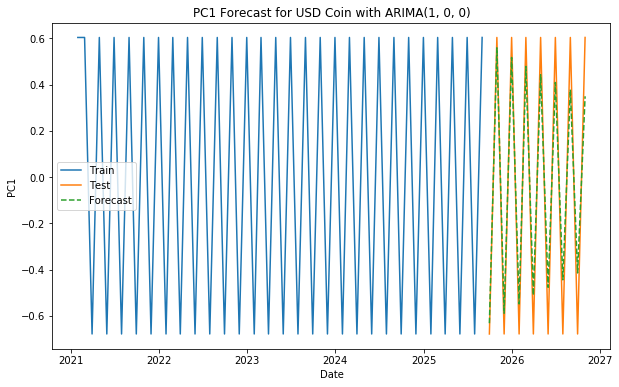

Mean Squared Error for USD Coin with ARIMA(1, 0, 0): 0.03037435883013031
Best ARIMA parameters for Tether USD: (1, 0, 0)


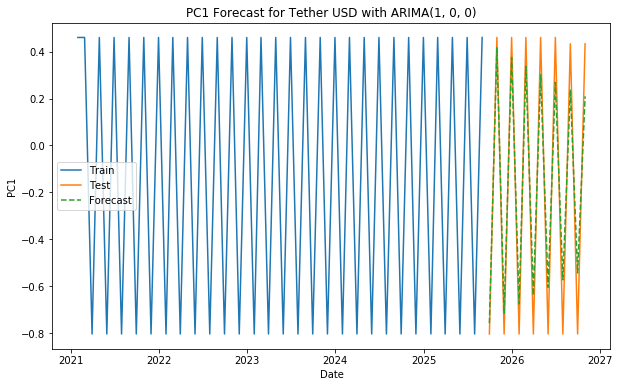

Mean Squared Error for Tether USD with ARIMA(1, 0, 0): 0.027799085442702508
Best ARIMA parameters for Dai Stablecoin: (1, 0, 0)


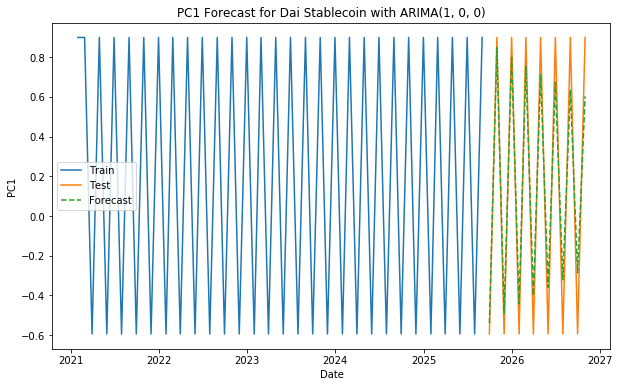

Mean Squared Error for Dai Stablecoin with ARIMA(1, 0, 0): 0.041139503079565425


In [31]:
# Load the data
df = pd.read_csv('../data/filtered_liquidity_data_with_pca.csv')

# Group by asset and perform the same analysis for each asset
for asset in assets_of_interest:
    asset_df = df[df['name'] == asset]

    # Generate a time index assuming monthly data points
    asset_df = asset_df.reset_index(drop=True)
    asset_df.index = pd.date_range(start='2021-01-01', periods=len(asset_df), freq='M')

    # Train-test split for time series forecasting with PC1
    train, test = train_test_split(asset_df['PC1'].dropna(), test_size=0.2, shuffle=False)

    # Grid search for best ARIMA parameters
    best_model, best_pdq = grid_search_arima(train)
    print(f'Best ARIMA parameters for {asset}: {best_pdq}')
    
    # Forecast using the best model
    forecast = best_model.forecast(steps=len(test))

    # Plot train, test, and forecast
    plt.figure(figsize=(10, 6))
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Test')
    plt.plot(test.index, forecast, label='Forecast', linestyle='--')
    plt.title(f'PC1 Forecast for {asset} with ARIMA{best_pdq}')
    plt.xlabel('Date')
    plt.ylabel('PC1')
    plt.legend()
    plt.show()

    # Calculate and print the mean squared error
    mse = mean_squared_error(test, forecast)
    print(f'Mean Squared Error for {asset} with ARIMA{best_pdq}: {mse}')


## SARIMA

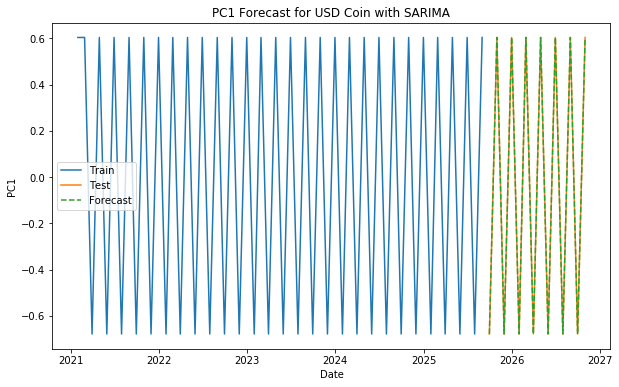

Mean Squared Error for USD Coin with SARIMA: 2.1455697751914966e-18


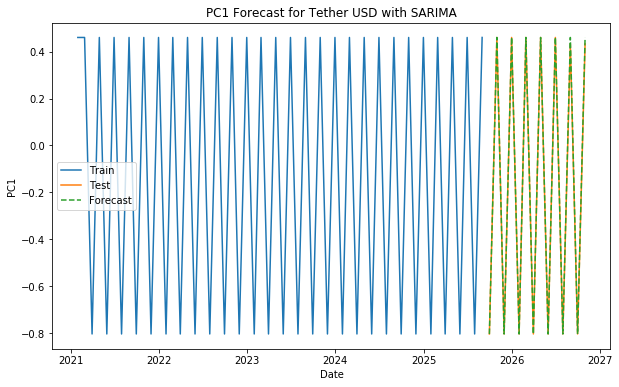

Mean Squared Error for Tether USD with SARIMA: 0.00010646385854481924


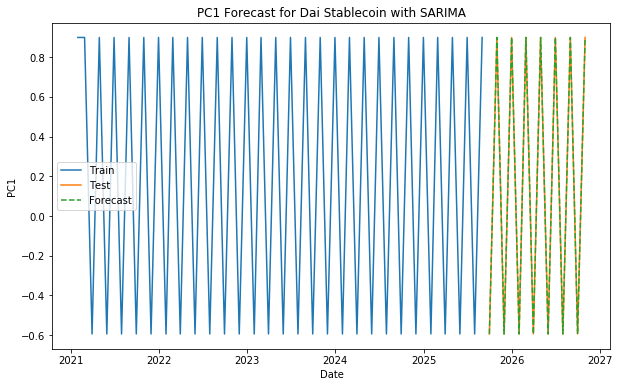

Mean Squared Error for Dai Stablecoin with SARIMA: 1.6497043995758119e-25


In [32]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def fit_sarima(train, seasonal_order):
    """Fit SARIMA model with given seasonal order."""
    sarima_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
    sarima_fit = sarima_model.fit(disp=False)
    return sarima_fit

# Define seasonal order
seasonal_order = (1, 1, 1, 12)  # Example of seasonal order (p, d, q, s)

# Group by asset and perform SARIMA analysis for each asset
for asset in assets_of_interest:
    asset_df = df[df['name'] == asset]

    # Generate a time index assuming monthly data points
    asset_df = asset_df.reset_index(drop=True)
    asset_df.index = pd.date_range(start='2021-01-01', periods=len(asset_df), freq='M')

    # Train-test split for time series forecasting with PC1
    train, test = train_test_split(asset_df['PC1'].dropna(), test_size=0.2, shuffle=False)

    # Fit SARIMA model on the training set
    sarima_fit = fit_sarima(train, seasonal_order)
    
    # Forecast using the SARIMA model
    forecast = sarima_fit.forecast(steps=len(test))

    # Plot train, test, and forecast
    plt.figure(figsize=(10, 6))
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Test')
    plt.plot(test.index, forecast, label='Forecast', linestyle='--')
    plt.title(f'PC1 Forecast for {asset} with SARIMA')
    plt.xlabel('Date')
    plt.ylabel('PC1')
    plt.legend()
    plt.show()

    # Calculate and print the mean squared error
    mse = mean_squared_error(test, forecast)
    print(f'Mean Squared Error for {asset} with SARIMA: {mse}')


## LSTM

In [34]:
!pip install fbprophet

ERROR: Could not find a version that satisfies the requirement httpstan<4.7,>=4.6 (from pystan>=2.14->fbprophet) (from versions: 0.9.0, 0.10.1, 1.0.0)
ERROR: No matching distribution found for httpstan<4.7,>=4.6 (from pystan>=2.14->fbprophet)
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [36]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

def create_lstm_model(input_shape):
    """Create LSTM model."""
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Group by asset and perform LSTM analysis for each asset
for asset in assets_of_interest:
    asset_df = df[df['name'] == asset]

    # Generate a time index assuming monthly data points
    asset_df = asset_df.reset_index(drop=True)
    asset_df.index = pd.date_range(start='2021-01-01', periods=len(asset_df), freq='M')

    # Train-test split for time series forecasting with PC1
    train, test = train_test_split(asset_df['PC1'].dropna(), test_size=0.2, shuffle=False)

    # Reshape data for LSTM model
    train_values = train.values.reshape(-1, 1)
    test_values = test.values.reshape(-1, 1)

    # Create sequences for LSTM
    def create_sequences(data, seq_length):
        X, y = [], []
        for i in range(len(data) - seq_length):
            X.append(data[i:i+seq_length])
            y.append(data[i+seq_length])
        return np.array(X), np.array(y)

    seq_length = 10
    X_train, y_train = create_sequences(train_values, seq_length)
    X_test, y_test = create_sequences(test_values, seq_length)

    # Create and train the LSTM model
    model = create_lstm_model((X_train.shape[1], 1))
    model.fit(X_train, y_train, batch_size=1, epochs=1)

    # Make predictions with LSTM model
    predictions = model.predict(X_test)
    
    # Plot train, test, and forecast
    plt.figure(figsize=(10, 6))
    plt.plot(train.index[seq_length:], y_train, label='Train')
    plt.plot(test.index[seq_length:], y_test, label='Test')
    plt.plot(test.index[seq_length:], predictions, label='Forecast', linestyle='--')
    plt.title(f'PC1 Forecast for {asset} with LSTM')
    plt.xlabel('Date')
    plt.ylabel('PC1')
    plt.legend()
    plt.show()

    # Calculate and print the mean squared error
    mse = mean_squared_error(y_test, predictions)
    print(f'Mean Squared Error for {asset} with LSTM: {mse}')


UnknownError:    Fail to find the dnn implementation.
	 [[{{node CudnnRNN}}]]
	 [[sequential/lstm/PartitionedCall]] [Op:__inference_train_function_4600]

Function call stack:
train_function -> train_function -> train_function


In [37]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def evaluate_forecast(test, forecast, model_name, asset_name):
    """Evaluate the forecast with additional metrics."""
    mae = mean_absolute_error(test, forecast)
    rmse = np.sqrt(mean_squared_error(test, forecast))
    print(f'{model_name} - {asset_name}: MAE = {mae}, RMSE = {rmse}')

# Use the evaluation function for SARIMA 
for asset in assets_of_interest:
    asset_df = df[df['name'] == asset]
    asset_df = asset_df.reset_index(drop=True)
    asset_df.index = pd.date_range(start='2021-01-01', periods=len(asset_df), freq='M')
    train, test = train_test_split(asset_df['PC1'].dropna(), test_size=0.2, shuffle=False)
    
    # SARIMA Evaluation
    sarima_fit = fit_sarima(train, seasonal_order)
    forecast_sarima = sarima_fit.forecast(steps=len(test))
    evaluate_forecast(test, forecast_sarima, 'SARIMA', asset)
    


SARIMA - USD Coin: MAE = 1.3994196198677651e-09, RMSE = 1.4647763567150777e-09
SARIMA - Tether USD: MAE = 0.0038998875177806585, RMSE = 0.010318132512466547
SARIMA - Dai Stablecoin: MAE = 1.7876176729357342e-13, RMSE = 4.061655327050551e-13


In [43]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def evaluate_forecast(test, forecast, model_name, asset_name):
    """Evaluate the forecast with additional metrics."""
    mae = mean_absolute_error(test, forecast)
    rmse = np.sqrt(mean_squared_error(test, forecast))
    print(f'{model_name} - {asset_name}: MAE = {mae}, RMSE = {rmse}')

# Use the evaluation function for SARIMA 
for asset in assets_of_interest:
    asset_df = df[df['name'] == asset]
    asset_df = asset_df.reset_index(drop=True)
    asset_df.index = pd.date_range(start='2021-01-01', periods=len(asset_df), freq='M')
    train, test = train_test_split(asset_df['PC1'].dropna(), test_size=0.2, shuffle=False)
    
    # SARIMA Evaluation
    sarima_fit = fit_sarima(train, seasonal_order)
    forecast_sarima = sarima_fit.forecast(steps=len(test))
    evaluate_forecast(test, forecast_sarima, 'SARIMA', asset)
    


SARIMA - USD Coin: MAE = 1.3994196198677651e-09, RMSE = 1.4647763567150777e-09
SARIMA - Tether USD: MAE = 0.0038998875177806585, RMSE = 0.010318132512466547
SARIMA - Dai Stablecoin: MAE = 1.7876176729357342e-13, RMSE = 4.061655327050551e-13


ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

Not enough data for asset: yearn.finance
Not enough data for asset: ChainLink Token


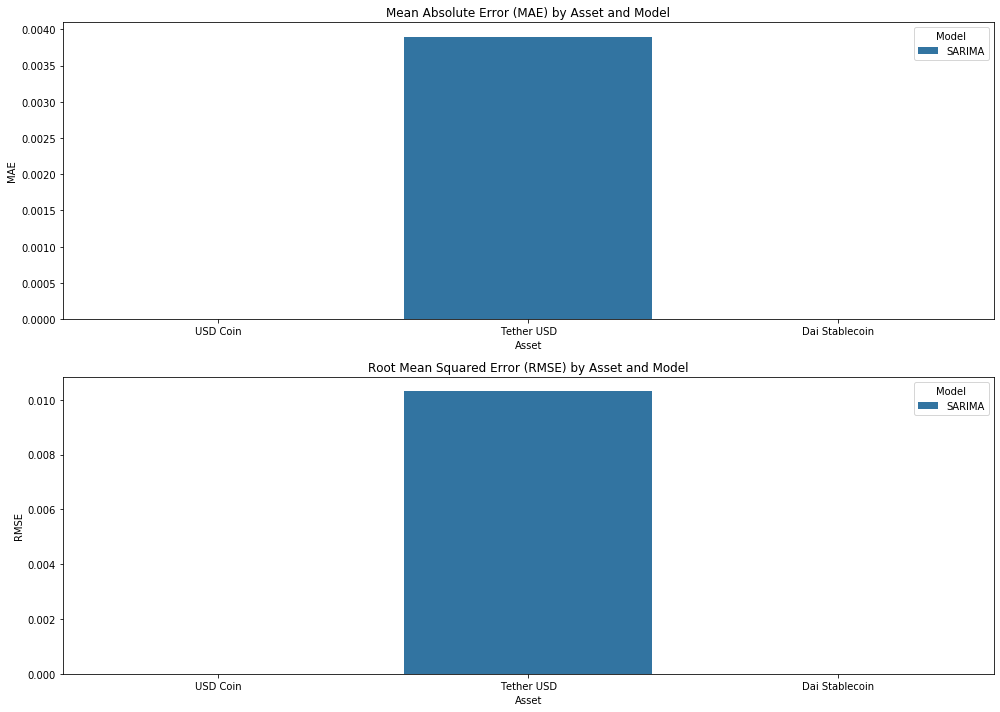

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Function to fit SARIMA model
def fit_sarima(train, seasonal_order):
    """Fit SARIMA model with given seasonal order."""
    sarima_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
    sarima_fit = sarima_model.fit(disp=False)
    return sarima_fit

# Function to evaluate forecasts
def evaluate_forecast(test, forecast, model_name, asset_name):
    """Evaluate the forecast with additional metrics and store the results."""
    mae = mean_absolute_error(test, forecast)
    rmse = np.sqrt(mean_squared_error(test, forecast))
    evaluation_results.append({'Model': model_name, 'Asset': asset_name, 'MAE': mae, 'RMSE': rmse})

# List to store evaluation results
evaluation_results = []

# Define seasonal order
seasonal_order = (1, 1, 1, 12)  # Example of seasonal order (p, d, q, s)

# Use the evaluation function for SARIMA 
for asset in assets_of_interest:
    asset_df = df[df['name'] == asset]

    # Ensure there is enough data for train-test split
    if len(asset_df) < 5:
        print(f"Not enough data for asset: {asset}")
        continue

    # Generate a time index assuming monthly data points
    asset_df = asset_df.reset_index(drop=True)
    asset_df.index = pd.date_range(start='2021-01-01', periods=len(asset_df), freq='M')

    # Train-test split for time series forecasting with PC1
    train_size = int(len(asset_df) * 0.8)
    if train_size == 0:
        print(f"Not enough data for train-test split for asset: {asset}")
        continue
    
    train = asset_df['PC1'].iloc[:train_size].dropna()
    test = asset_df['PC1'].iloc[train_size:].dropna()

    if len(test) == 0:
        print(f"Not enough test data for asset: {asset}")
        continue

    # SARIMA Evaluation
    sarima_fit = fit_sarima(train, seasonal_order)
    forecast_sarima = sarima_fit.forecast(steps=len(test))
    evaluate_forecast(test, forecast_sarima, 'SARIMA', asset)

# Convert results to DataFrame
evaluation_df = pd.DataFrame(evaluation_results)

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(14, 10))

# MAE Plot
sns.barplot(x='Asset', y='MAE', hue='Model', data=evaluation_df, ax=axs[0])
axs[0].set_title('Mean Absolute Error (MAE) by Asset and Model')
axs[0].set_ylabel('MAE')
axs[0].set_xlabel('Asset')
axs[0].legend(title='Model')

# RMSE Plot
sns.barplot(x='Asset', y='RMSE', hue='Model', data=evaluation_df, ax=axs[1])
axs[1].set_title('Root Mean Squared Error (RMSE) by Asset and Model')
axs[1].set_ylabel('RMSE')
axs[1].set_xlabel('Asset')
axs[1].legend(title='Model')

plt.tight_layout()
plt.show()


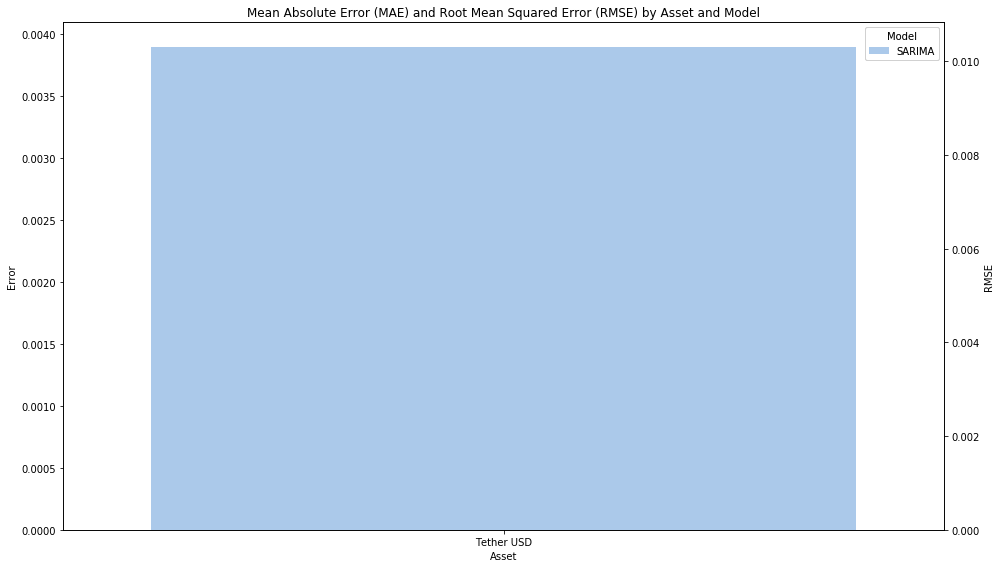

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Function to fit SARIMA model
def fit_sarima(train, seasonal_order):
    """Fit SARIMA model with given seasonal order."""
    sarima_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
    sarima_fit = sarima_model.fit(disp=False)
    return sarima_fit

# Function to evaluate forecasts
def evaluate_forecast(test, forecast, model_name, asset_name):
    """Evaluate the forecast with additional metrics and store the results."""
    mae = mean_absolute_error(test, forecast)
    rmse = np.sqrt(mean_squared_error(test, forecast))
    evaluation_results.append({'Model': model_name, 'Asset': asset_name, 'MAE': mae, 'RMSE': rmse})

# List to store evaluation results
evaluation_results = []

# Define seasonal order
seasonal_order = (1, 1, 1, 12)  # Example of seasonal order (p, d, q, s)

# Use the evaluation function for SARIMA 
for asset in ['Tether USD']:
    asset_df = df[df['name'] == asset]

    # Ensure there is enough data for train-test split
    if len(asset_df) < 5:
        print(f"Not enough data for asset: {asset}")
        continue

    # Generate a time index assuming monthly data points
    asset_df = asset_df.reset_index(drop=True)
    asset_df.index = pd.date_range(start='2021-01-01', periods=len(asset_df), freq='M')

    # Train-test split for time series forecasting with PC1
    train_size = int(len(asset_df) * 0.8)
    if train_size == 0:
        print(f"Not enough data for train-test split for asset: {asset}")
        continue
    
    train = asset_df['PC1'].iloc[:train_size].dropna()
    test = asset_df['PC1'].iloc[train_size:].dropna()

    if len(test) == 0:
        print(f"Not enough test data for asset: {asset}")
        continue

    # SARIMA Evaluation
    sarima_fit = fit_sarima(train, seasonal_order)
    forecast_sarima = sarima_fit.forecast(steps=len(test))
    evaluate_forecast(test, forecast_sarima, 'SARIMA', asset)

# Convert results to DataFrame
evaluation_df = pd.DataFrame(evaluation_results)

# Plotting
fig, ax = plt.subplots(figsize=(14, 8))

# MAE and RMSE Plot
sns.barplot(x='Asset', y='MAE', hue='Model', data=evaluation_df, ax=ax)
ax.set_title('Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) by Asset and Model')
ax.set_ylabel('Error')
ax.set_xlabel('Asset')
ax.legend(title='Model')

# Adding RMSE values as a secondary y-axis
ax2 = ax.twinx()
sns.barplot(x='Asset', y='RMSE', hue='Model', data=evaluation_df, ax=ax2, palette='pastel')
ax2.set_ylabel('RMSE')

plt.tight_layout()
plt.show()
